In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [8]:
def tsp_objective_function(p, A, n):
    s = 0.0
    for i in range(n):
        s += A[p[i-1], p[i]]
    return s

In [9]:
def parse_tsp(filename):
    data = ""
    with open(filename) as fh:
        data = fh.read().split("\n")
    n = int(data[3].split()[1])
    e_type = data[4].split()[1]
    e_format = ""
    if e_type == "EXPLICIT":
        e_format = data[5].split()[1]
    
    A = np.empty((n, n), dtype=int)
    if e_type == "EXPLICIT" and e_format == "UPPER_ROW":
        for i in range(n-1):
            edges = map(int, data[i+8].split())
            for j, v in enumerate(edges):
                A[i, i + j + 1] = v
                A[i + j + 1, i] = v
        for i in range(n):
            A[i, i] = 0

    if e_type == "EXPLICIT" and e_format == "FULL_MATRIX":
        for i in range(n):
            edges = map(int, data[i+8].split())
            for j, v in enumerate(edges):
                A[i, j] = v
    if e_type == "EUC_2D":
        coords = np.empty((n,2))
        for i in range(n):
            coord = list(map(int, data[i+6].split()))
            coords[coord[0]-1, :] = np.array([coord[1:]])
        for i in range(n):
            for j in range(n):
                A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
    return A, n

In [10]:
def random_subproblem(A, n, n_):
    picked_v = np.sort(np.random.choice(range(n), n_, replace=False))
    return A[np.array(picked_v)[:,None], np.array(picked_v)], n_


In [11]:
from itertools import combinations, permutations

# only for symmetrical tsp

def improvePath(ind, A, n):
    g = -np.inf
    best_i = 0
    for i in range(ind.size-1):
        g_ = A[ind[i], ind[i+1]] - A[ind[i], ind[-1]]
        if g_ > g:
            g = g_
            best_i = i
    if g <= 0: 
        return None
    return np.hstack([ind[:best_i], np.flipud(ind[best_i:])])

def intensify(ind, A, n):
    improvement = True
    ind_score = tsp_objective_function(ind, A, n)
    while improvement:
        improvement = False
        for i in range(ind.size):
            res = improvePath(ind, A, n)
            if res is not None:
                res_score = tsp_objective_function(res, A, n)
                if res_score < ind_score:
                    ind = res
                    ind_score = res_score
                    improvement = True
                    break
            ind = np.roll(ind, -1)
    return ind

In [12]:
def double_bridge(ind):
    s = np.sort(np.random.choice(ind.size, 3, replace=False))
    return np.hstack([ind[:s[0]], ind[s[2]:], ind[s[1]:s[2]], ind[s[0]:s[1]]])

def perturbate(ind, K):
    ind_ = ind.copy()
    for i in range(K):
        ind_ = double_bridge(ind_)
    return ind_

def norm(ind):
    i = np.where(ind == 1)[0][0]
    return np.roll(ind, -i)


In [13]:
def CLK(I, A):
    n = A.shape[0]
    s = np.random.permutation(n)
    s_res = tsp_objective_function(s, A, n)
    L = set([tuple(s)])
    E = {}
    i = 0
    while i < I:
        p = perturbate(s, 1)
        p = intensify(p, A, n)
        p_res = tsp_objective_function(p, A, n)
        i += 1
        if p_res < s_res:
            L.add(tuple(norm(p)))
            e = (tuple(norm(s)), tuple(norm(p)))
            if e in E:
                E[e] += 1
            else:
                E[e] = 1
            s = p
            s_res = p_res
            i = 0
    return s_res, L, E

In [14]:
import pickle

def save_graph(V, E, A, n, file_name):
    with open(file_name, "wb") as fh:
        pickle.dump((V, E, A, n), fh)
    
def load_graph(file_name):
    with open(file_name, "rb") as fh:
        (V, E, A, n) = pickle.load(fh)
        return V, E, A, n

In [15]:
from multiprocessing import Pool
import time

def generate_graph(A, n, out_filename):
    T = 1000
    I = 10000
    L = set()
    E = {}


    pool = Pool()
    begin = time.time()
    for s_res, L_, E_ in pool.starmap(CLK, [(I, A) for t in range(T)]):
        L = L | L_
        for k, v in E_.items():
            if k in E:
                E[k] += v
            else:
                E[k] = v

    print((time.time() - begin))
    save_graph(L, E, A, n, out_filename+".g")


In [16]:
def generate_subproblems_graphs(A, n, out_filename, T, s):
    for t in range(T):
        A_, n_ = random_subproblem(A, n, n-s)
        sub_name = out_filename + "_" + str(s) + "_" + str(t)
        generate_graph(A_, n_, sub_name)
        print(sub_name)


In [17]:
def adjacency_list(V, E):
    E_ = {}
    for s1, s2 in E:
        if s1 in V and s2 in V:
            if s1 in E_:
                E_[s1].append(s2)
            else:
                E_[s1] = [s2]
    return E_

def dfs(v, V, E, g_min, prev, A, n):
    if tsp_objective_function(v, A, n) == g_min:
        return True
    if v not in E:
        return False
    for u in E[v]:
        if u == prev:
            continue
        if dfs(u, V, E, g_min, v, A, n):
            return True
    return False

def find_pos_glob(V, E, g_min, A, n):
    E_ = adjacency_list(V, E)
    pos_glob = set()
    for v in V.keys():
        if dfs(v, V, E_, g_min, None, A, n):
            pos_glob.add(v)
    return pos_glob

def get_edges_probs(V, E):
    E_ = adjacency_list(V, set(E.keys()))
    E_probs = {}
    for v, l in E_.items():
        s = sum([E[(v, neigh)] for neigh in l])
        for neigh in l:
            E_probs[(v, neigh)] = E[(v, neigh)] / s
    return E_probs

In [18]:
import igraph

def generate_image(filename):
    V, E, A, n = load_graph(filename + ".g")
    E_probs = get_edges_probs(V, E)
    E = set(E.keys())
    results = sorted([tsp_objective_function(s, A, n) for s in V])
    g_min = results[0]
    threshold = results[len(results) // 10]
    V = { s for s in V if tsp_objective_function(s, A, n) <= threshold}
    V_ = { s : (i, tsp_objective_function(s, A, n)) for i, s in enumerate(V)}

    Not_Sinks = set()
    for s in V:
        for (v, u) in E:
            if v == s:
                Not_Sinks.add(s)
                break

    V_c = [0 for i in range(len(V_))]
    for s, (i, r) in V_.items():
        V_c[i] = (s, r)
    E_ = [(V_[s1][0], V_[s2][0]) for s1, s2 in E if s1 in V_ and s2 in V_]
    E_size = [5 * E_probs[s1, s2] for s1, s2 in E if s1 in V_ and s2 in V_]
    pos_glob = find_pos_glob(V_, E, g_min, A, n)

    g = igraph.Graph(directed=True)
    g.add_vertices(len(V_))
    g.add_edges(E_)

    visual_style = {}
    visual_style["layout"] = \
        g.layout_fruchterman_reingold(maxiter=3000)
    visual_style["vertex_color"] = ['red' if t[0] in pos_glob else 'blue'
                for t in V_c]
    visual_style["vertex_frame_color"] = \
        [visual_style["vertex_color"][i] if t[0] in Not_Sinks else 'black'
        for i, t in enumerate(V_c)]
    visual_style["vertex_frame_width"] = [2 for i in V_c]
    visual_style["vertex_size"] = [10 if t[0] in Not_Sinks else 20 for t in V_c]
    visual_style["edge_width"] = E_size
    visual_style["bbox"] = (0, 0, 1800, 1000)

    igraph.summary(g)
    out = igraph.plot(g, **visual_style)
    print(filename)
    out.save(filename + ".png")  

In [19]:
def subproblems_graphs(tsp_file, out_file, T, s):
    A, n = parse_tsp(tsp_file + ".tsp")
    generate_subproblems_graphs(A, n, out_file, T, s)

In [ ]:
subproblems_graphs("bays29", "graphs/bays29", 9, 1)
subproblems_graphs("bays29", "graphs/bays29", 9, 2)
subproblems_graphs("bays29", "graphs/bays29", 10, 5)


In [5]:
def gen_sub_images(filename, T, s):
    for t in range(T):
        sub_file = filename + "_" + str(s) + "_" + str(t)
        generate_image(sub_file)

In [ ]:
gen_sub_images("graphs/bays29", 9, 1)
gen_sub_images("graphs/bays29", 9, 2)
gen_sub_images("graphs/bays29", 10, 5)

IGRAPH D--- 146 112 -- 
bays29


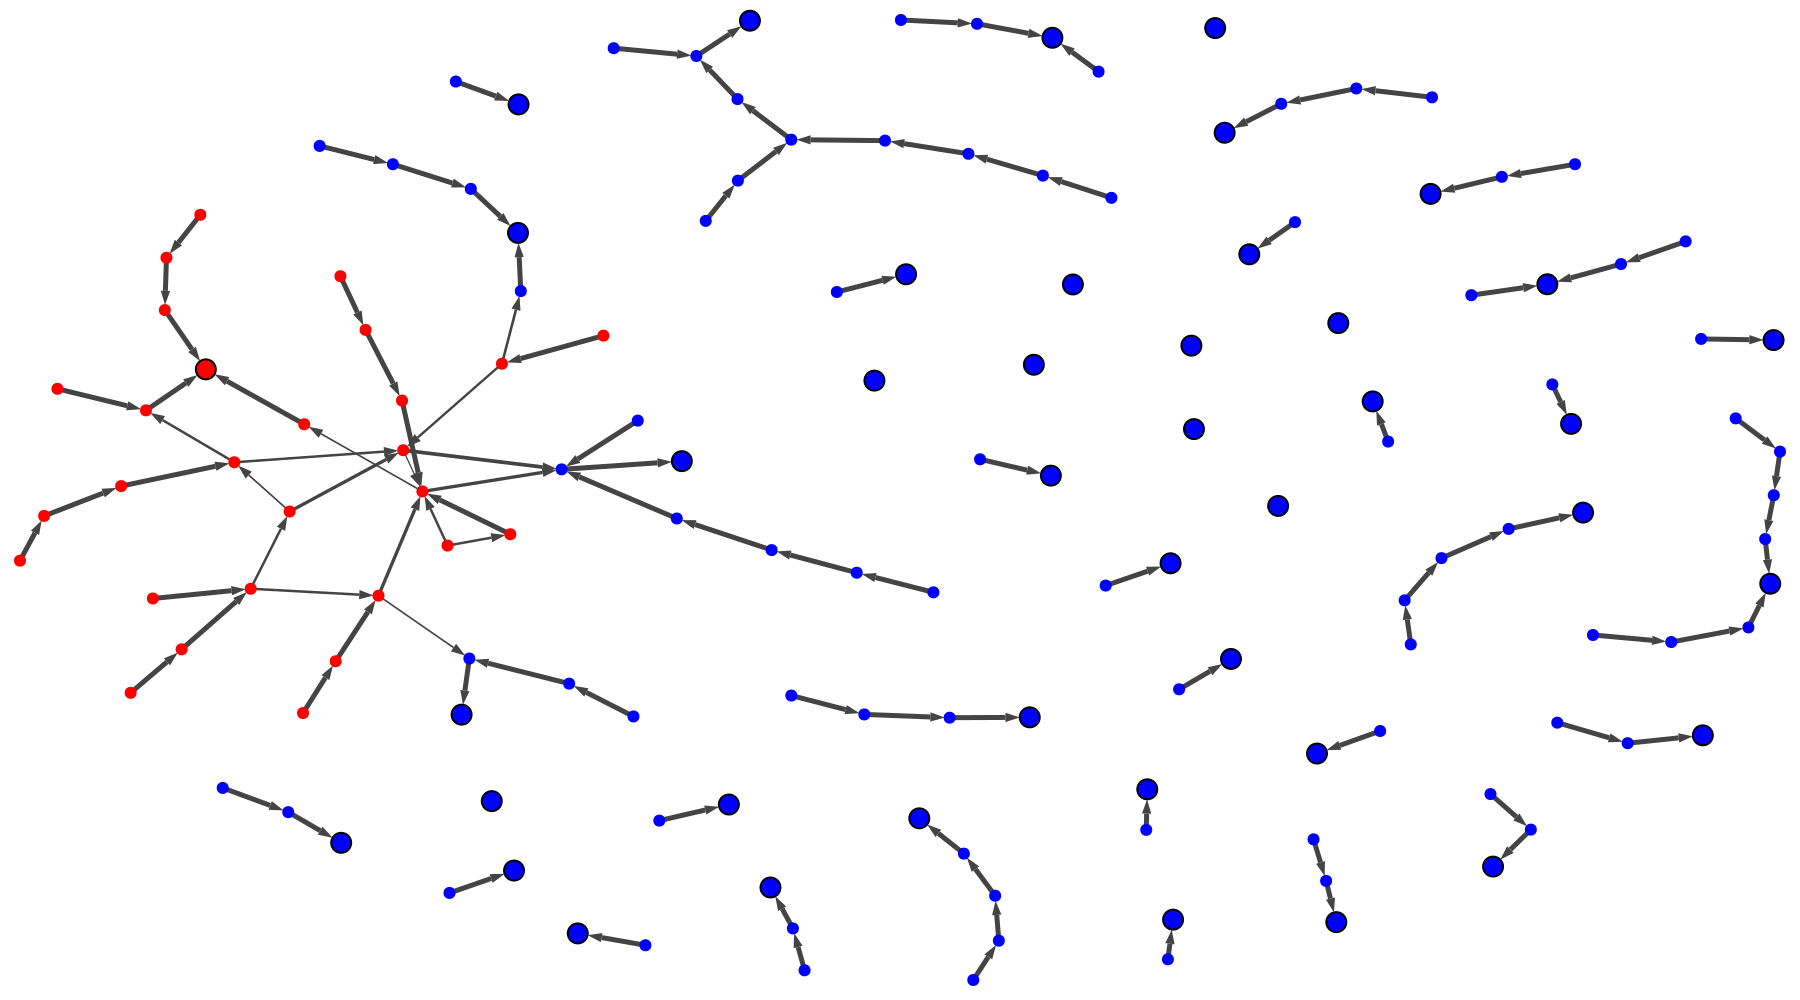

In [23]:
from IPython.display import Image, display

generate_image("bays29")
Image("bays29.png")

graphs/bays29_1_0.png


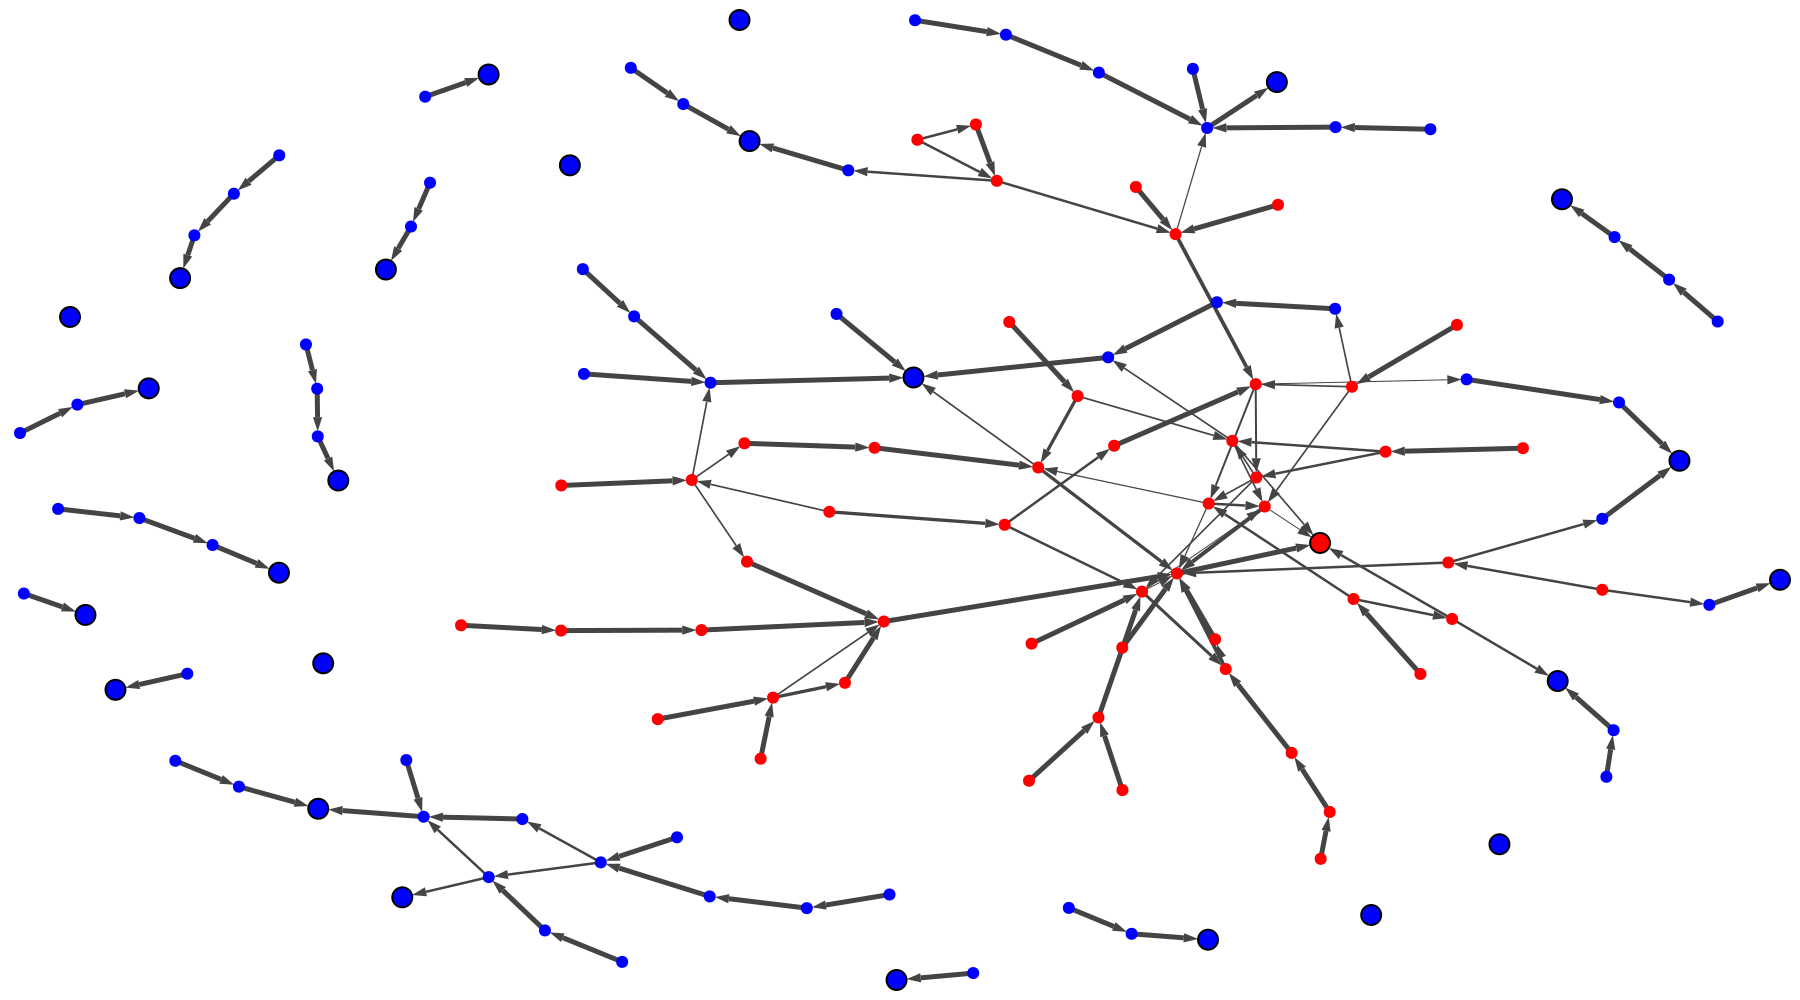

graphs/bays29_1_1.png


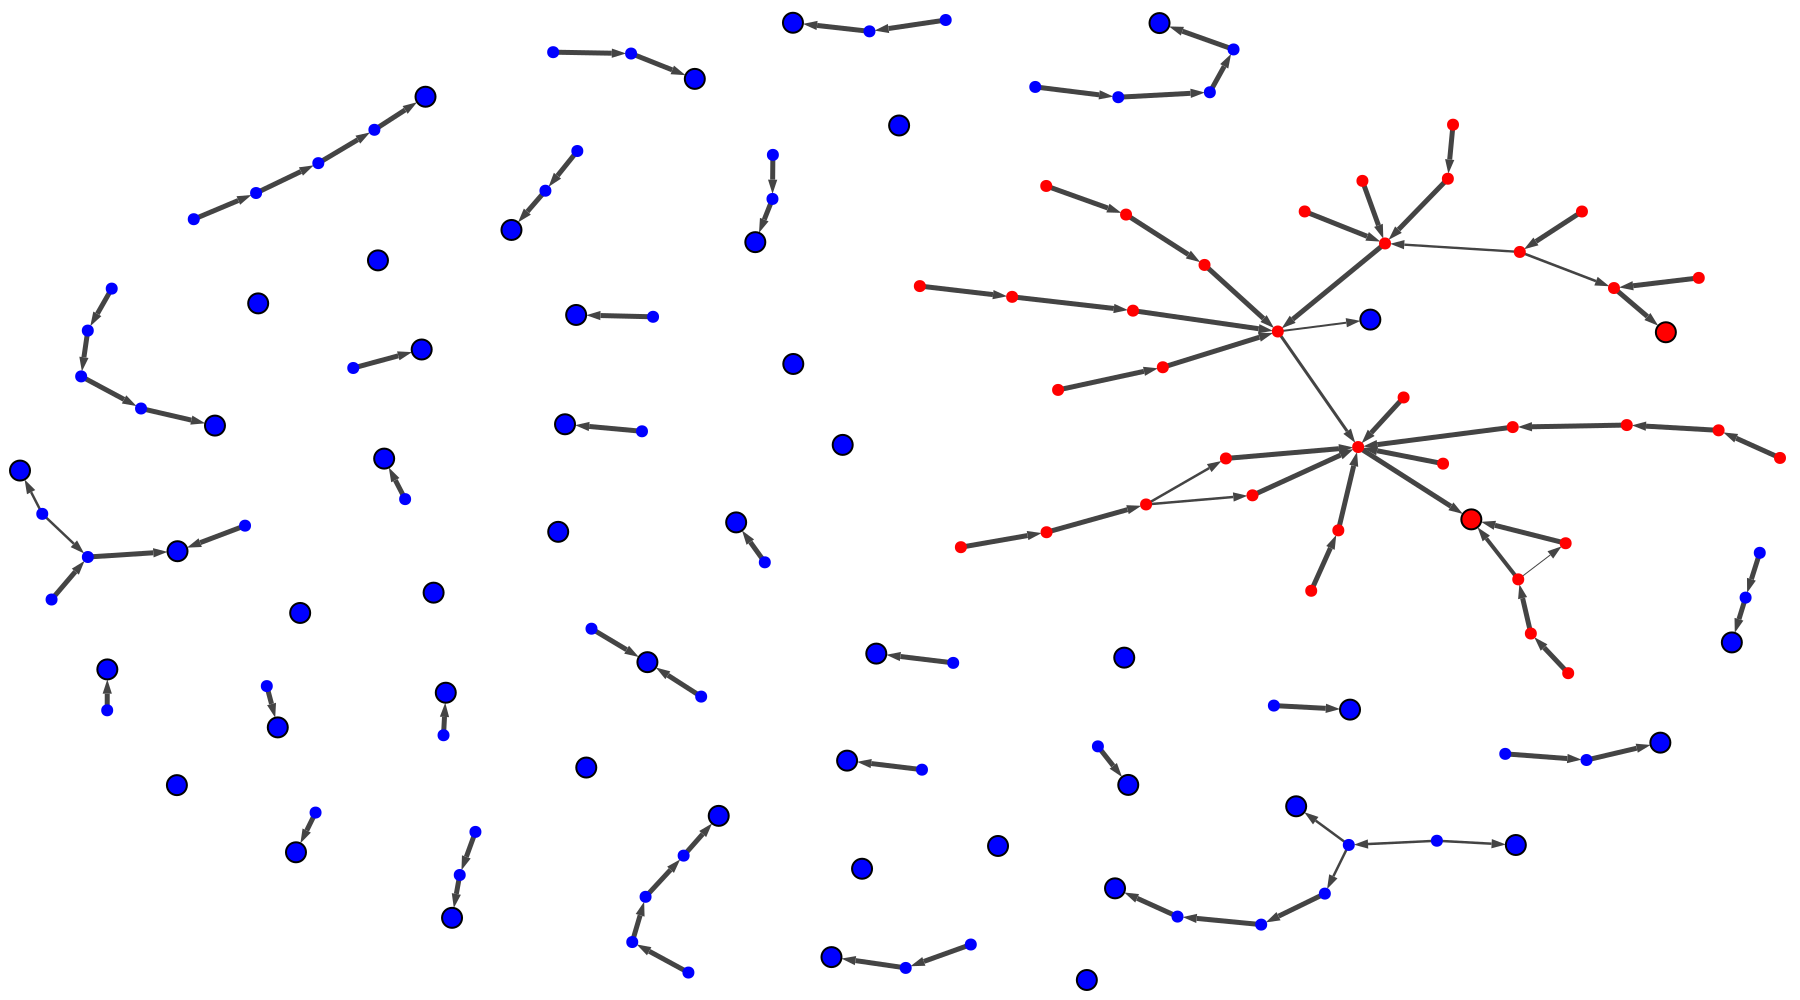

graphs/bays29_1_2.png


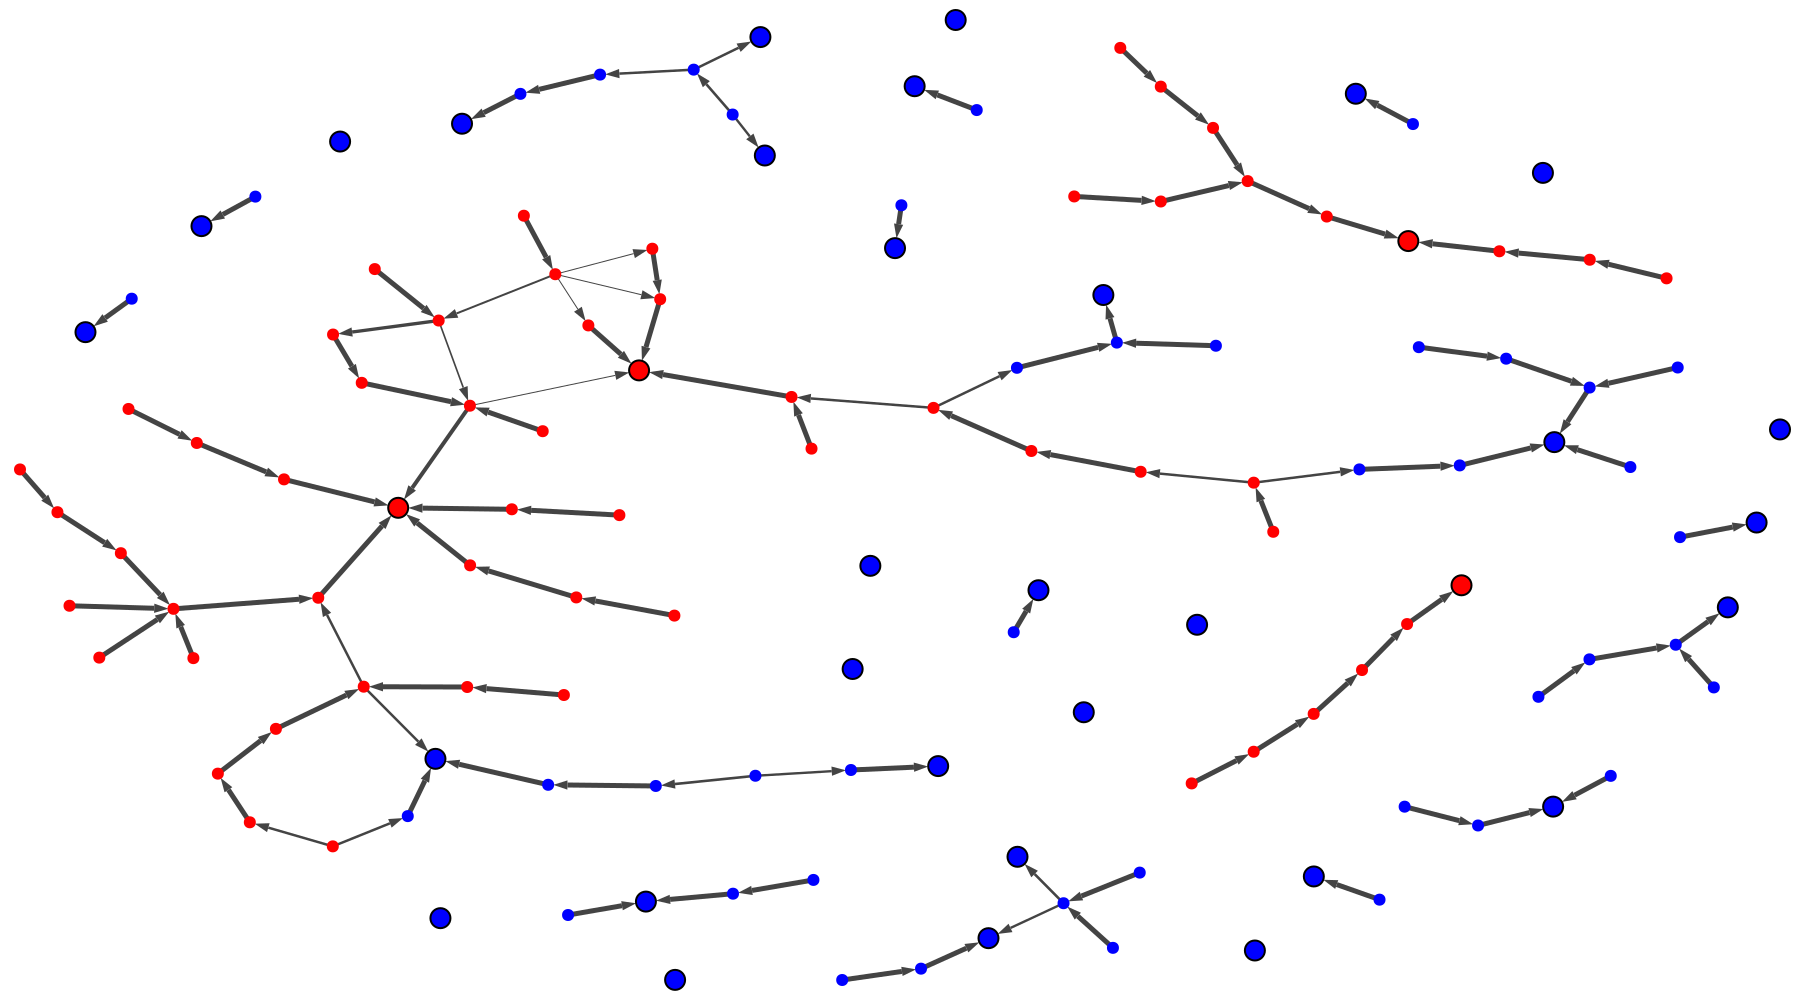

graphs/bays29_1_3.png


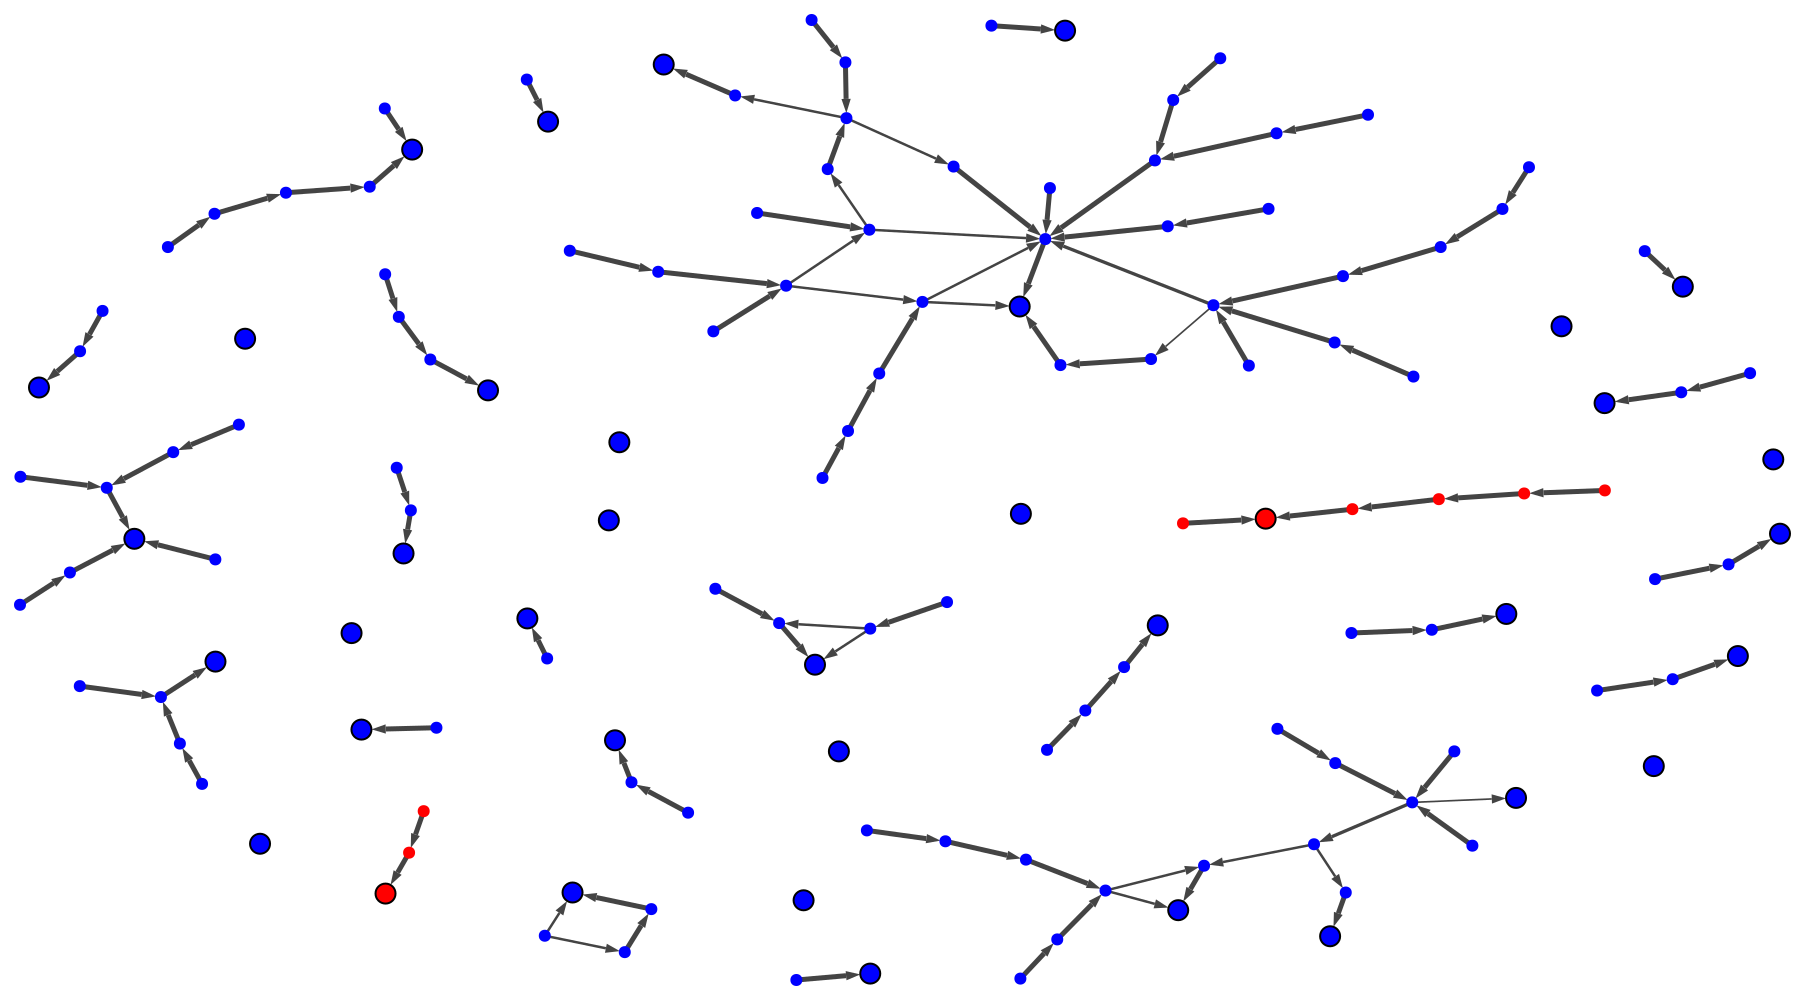

graphs/bays29_1_4.png


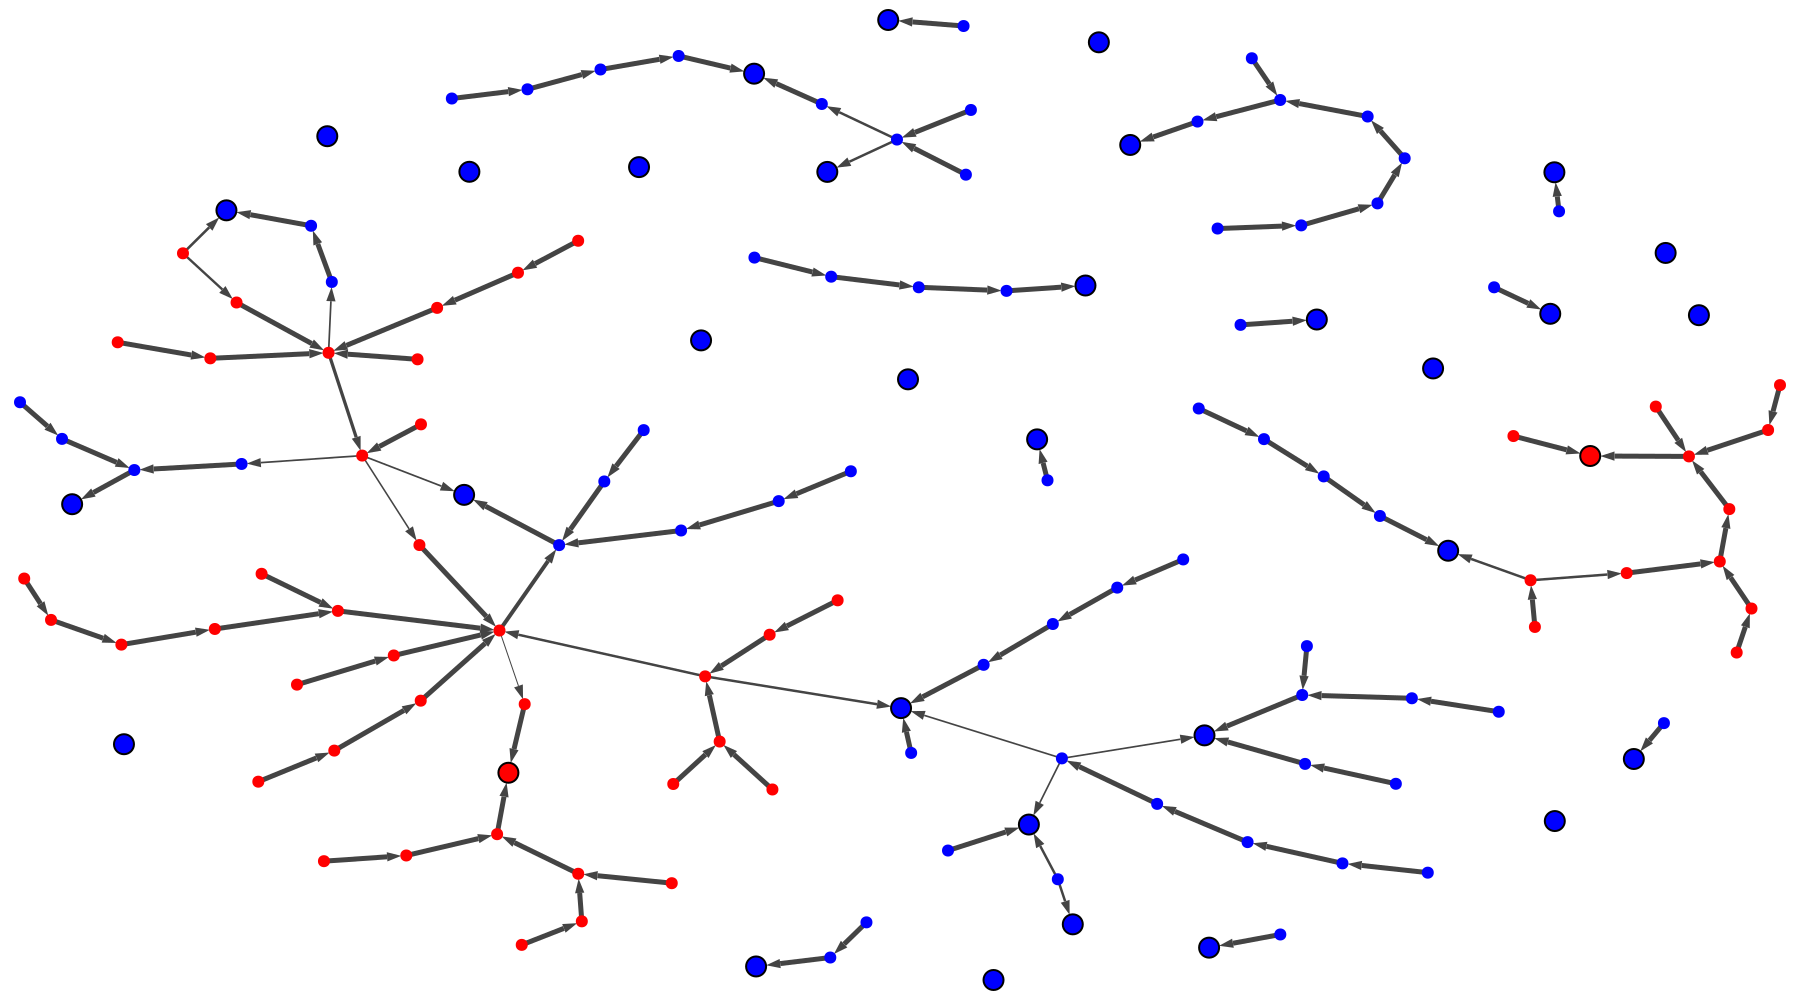

graphs/bays29_1_5.png


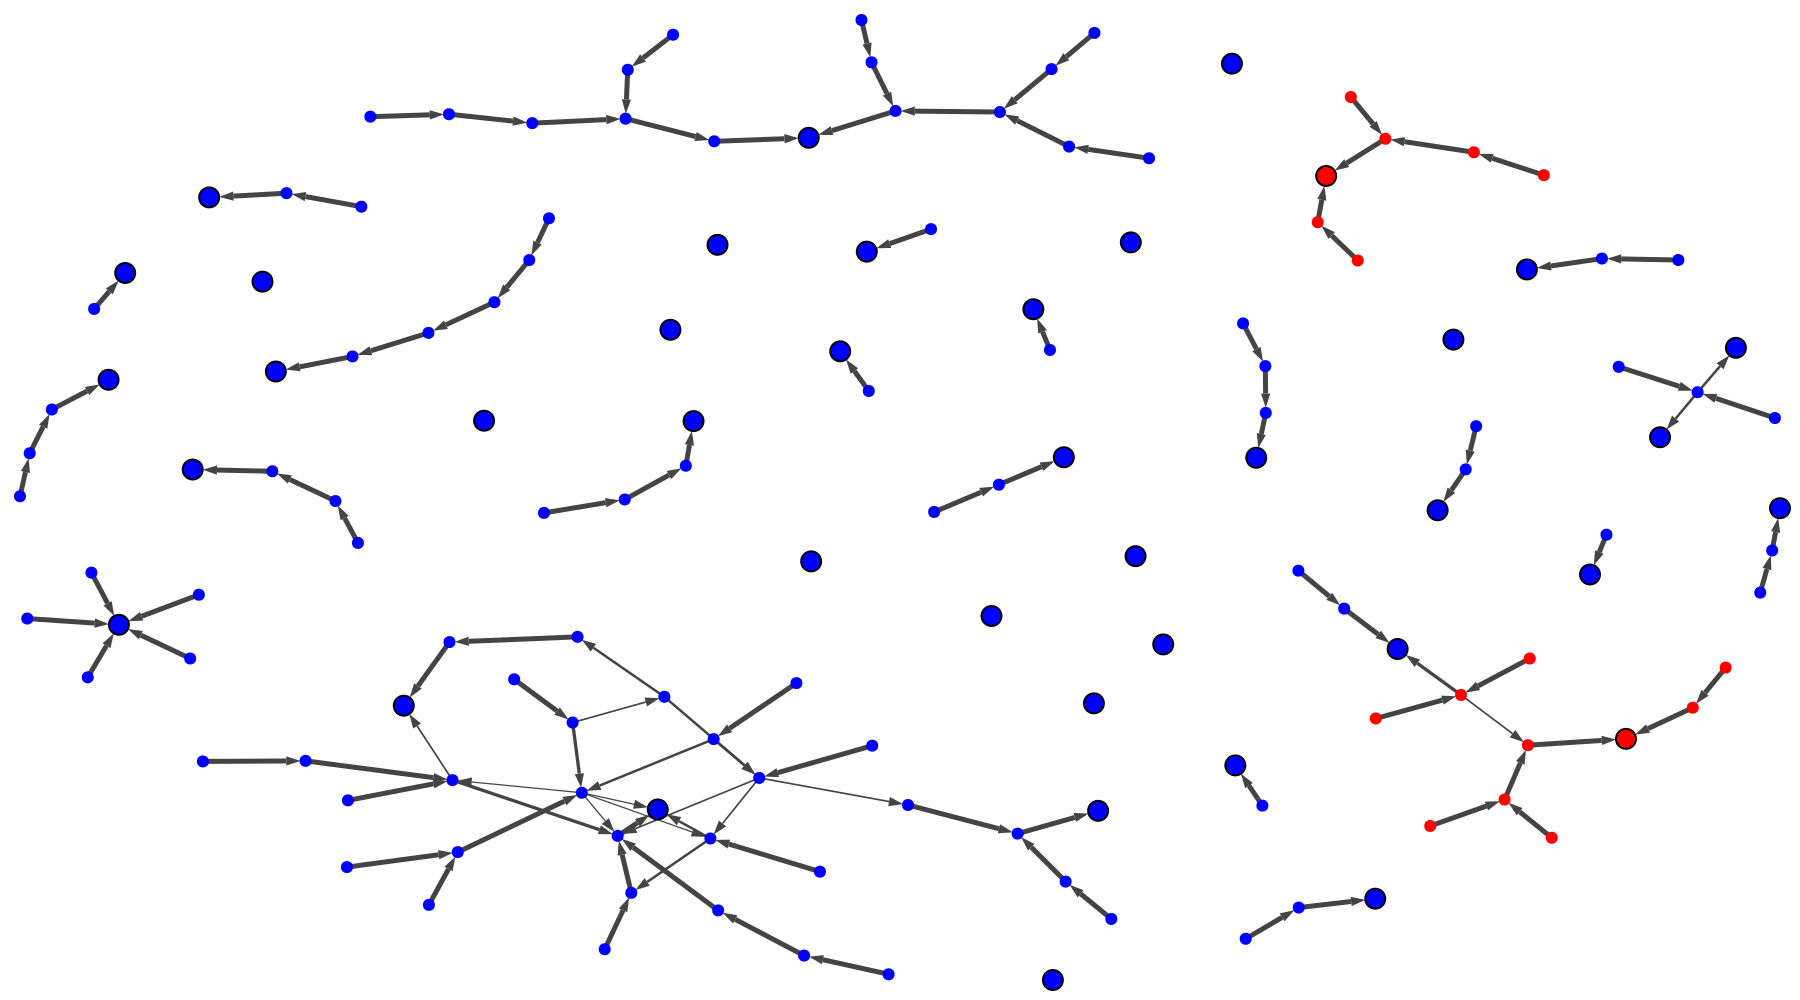

graphs/bays29_1_6.png


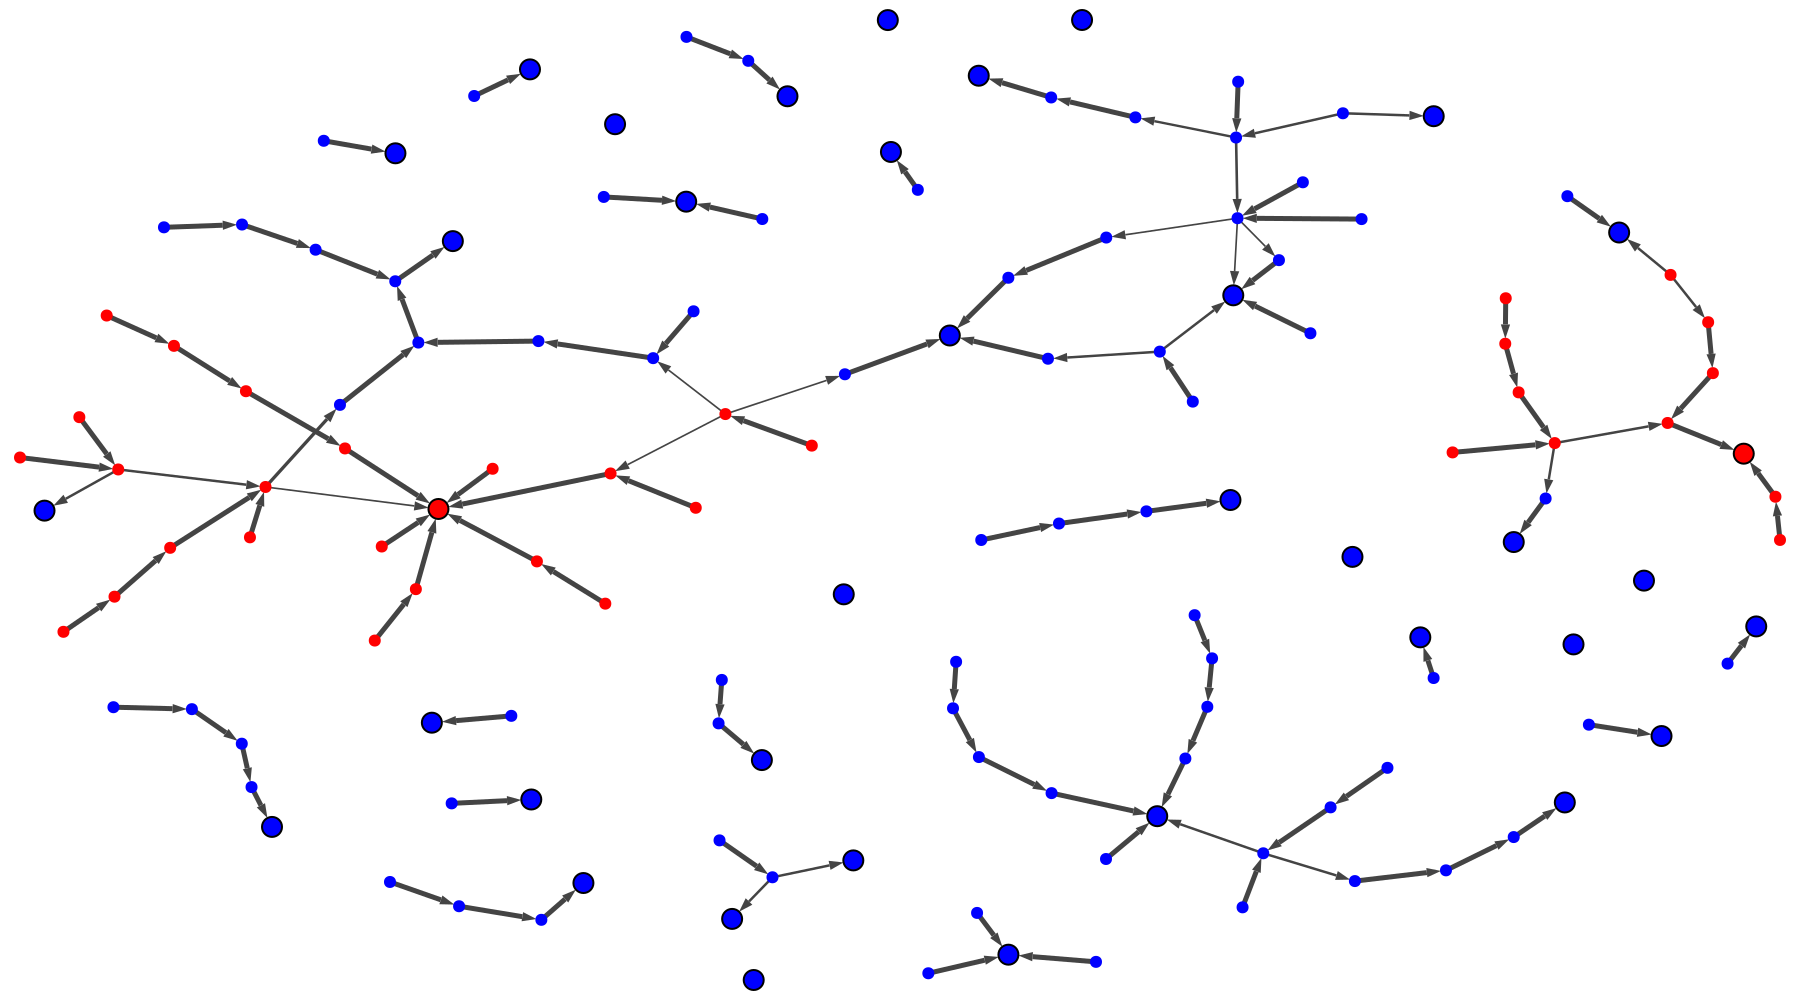

graphs/bays29_1_7.png


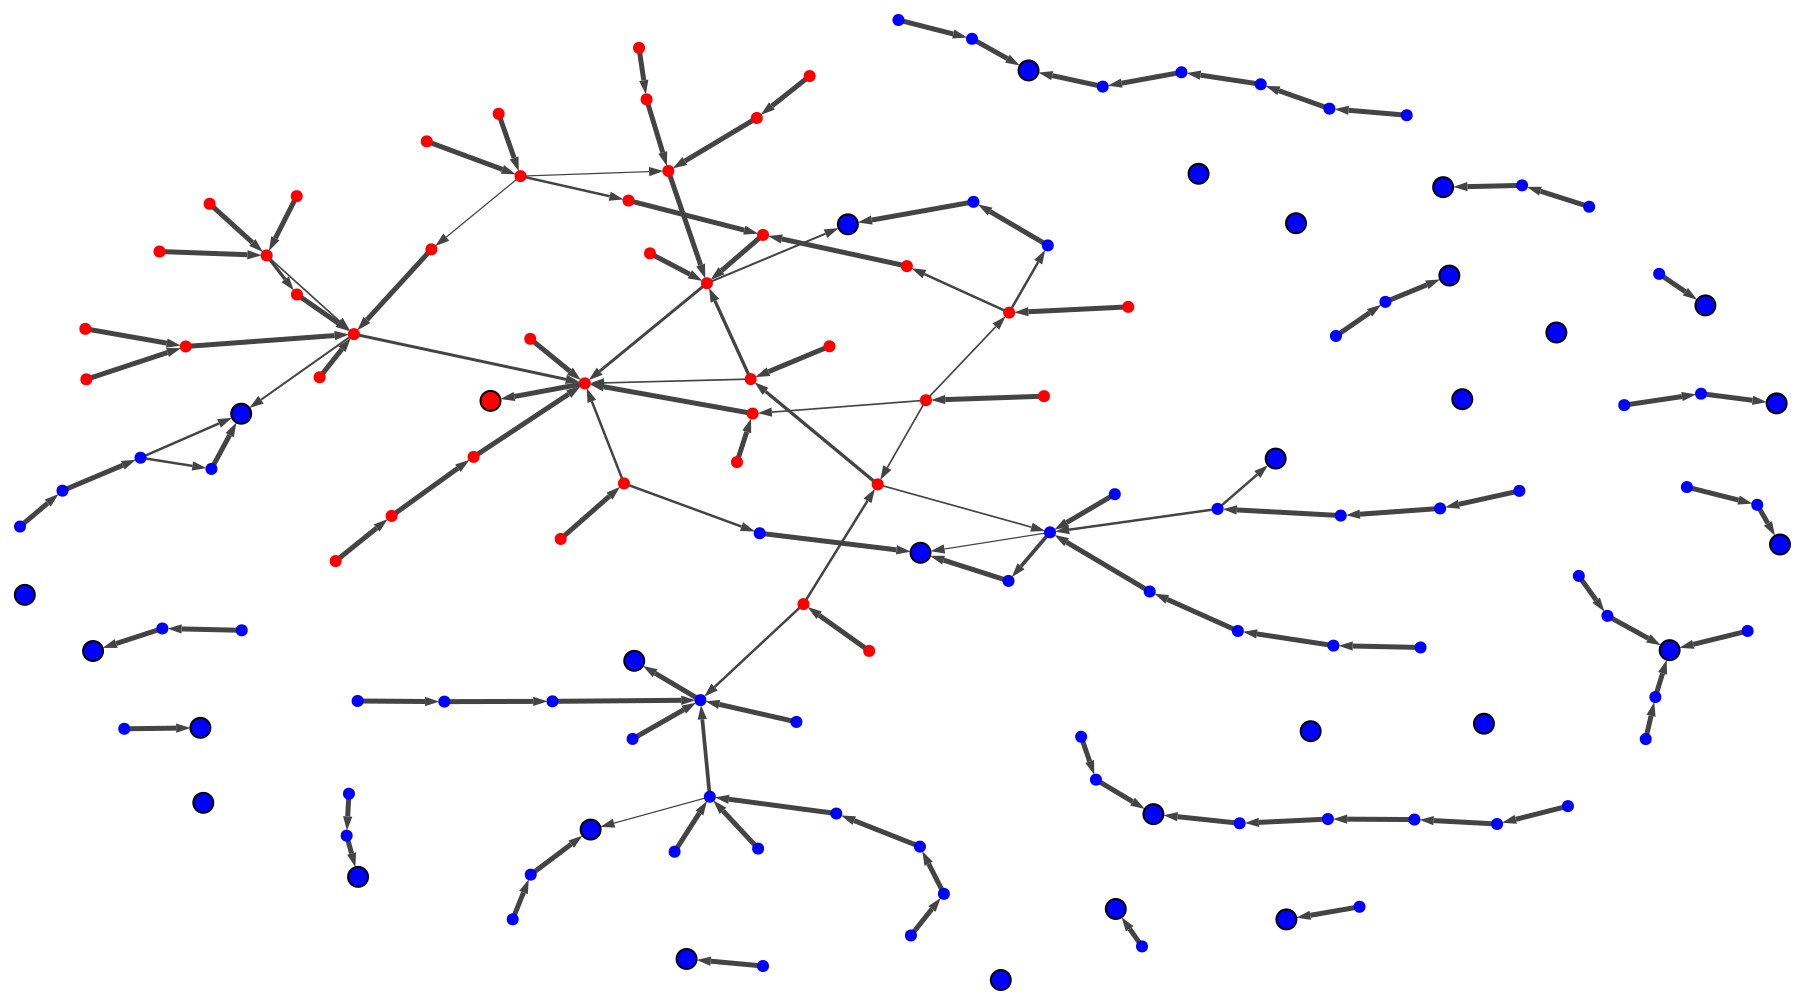

graphs/bays29_1_8.png


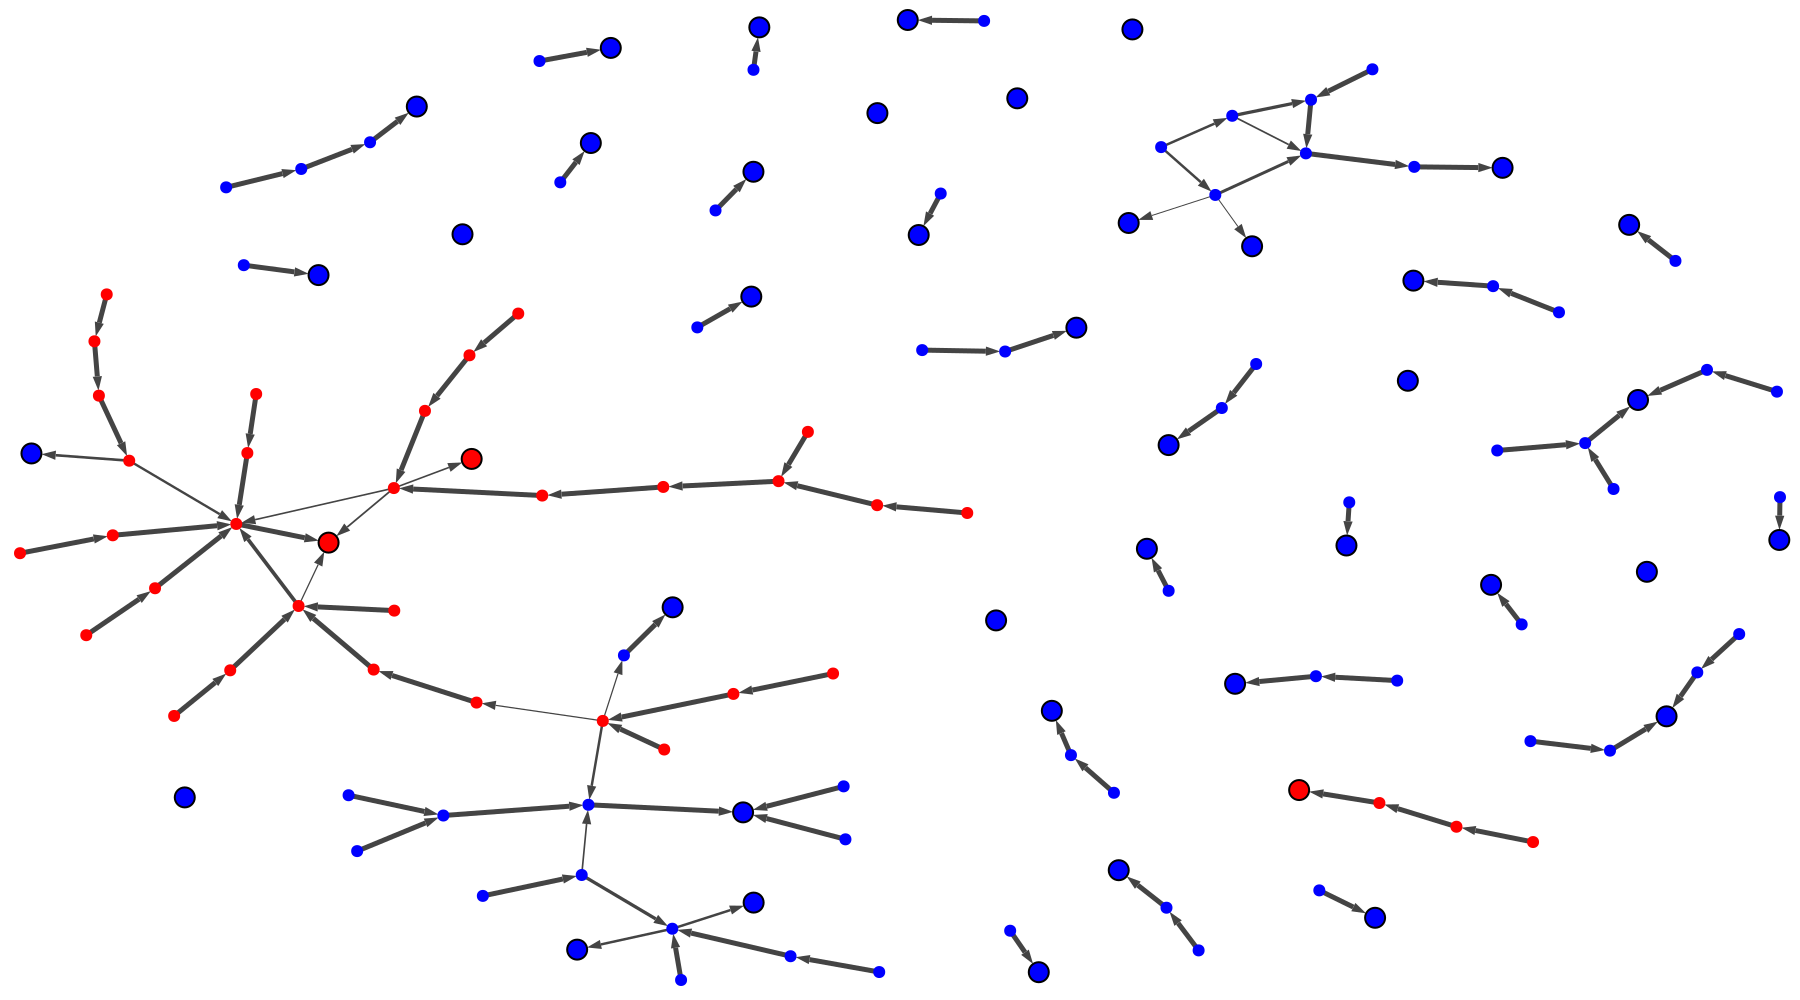

graphs/bays29_2_0.png


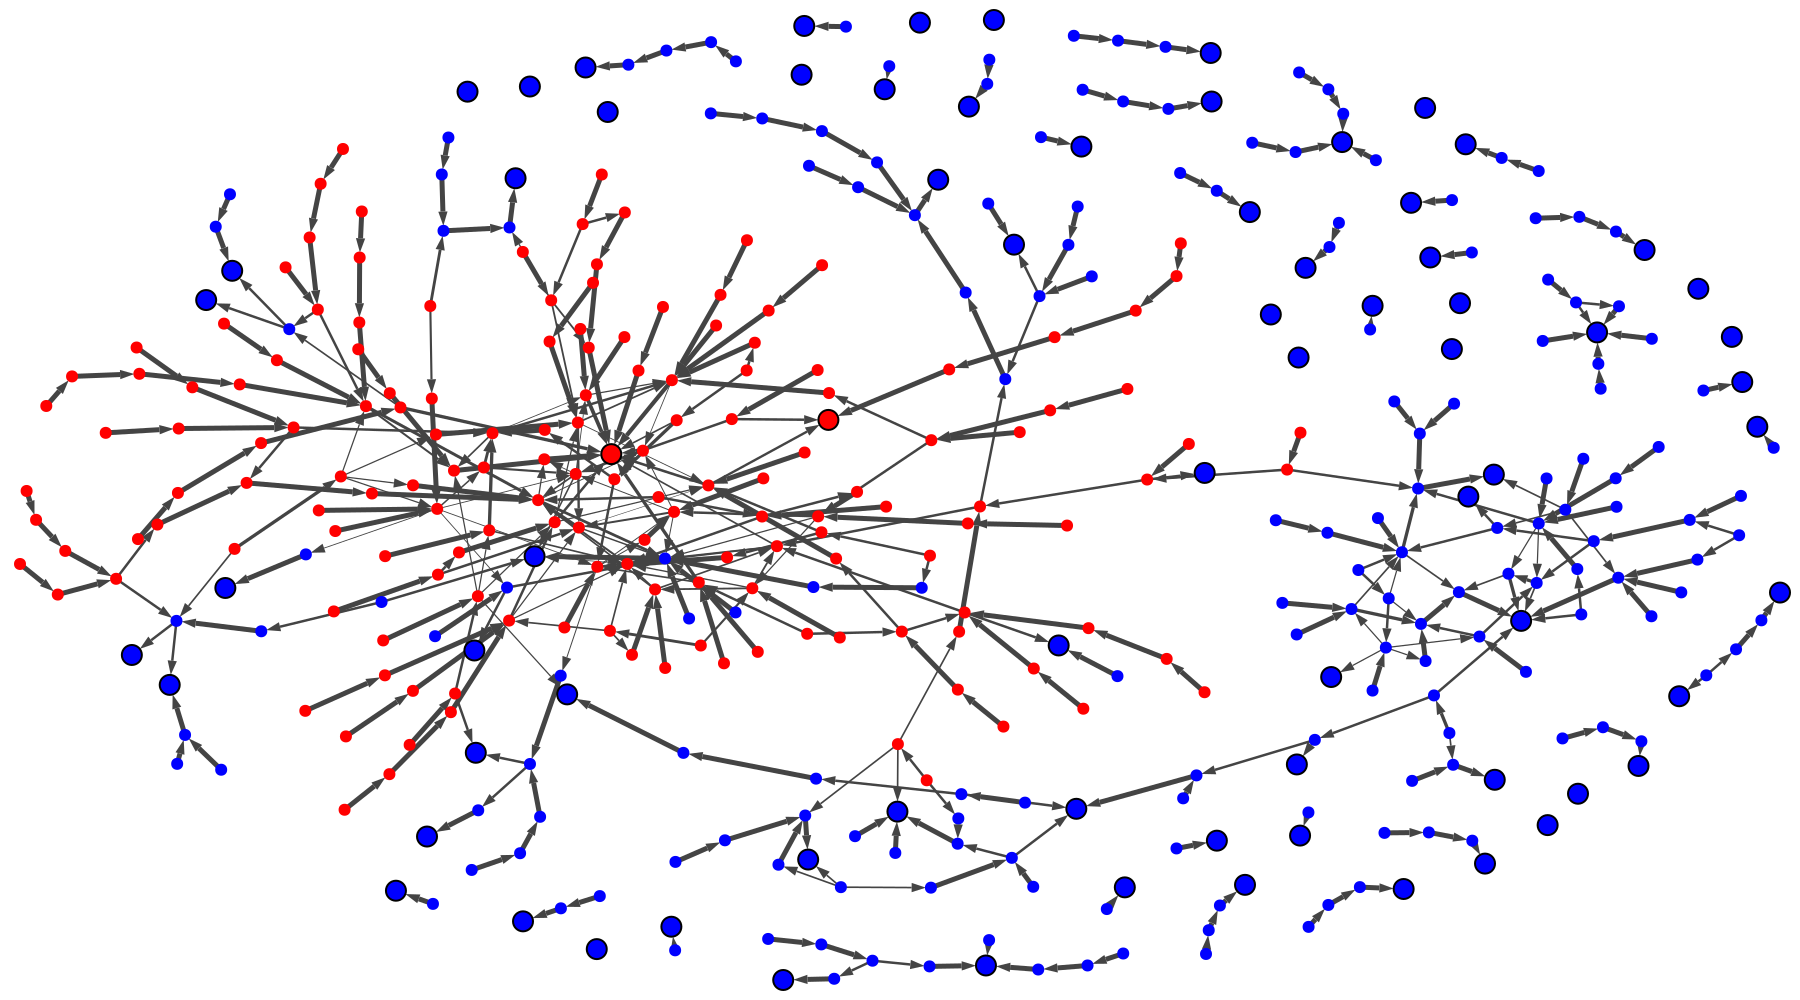

graphs/bays29_2_1.png


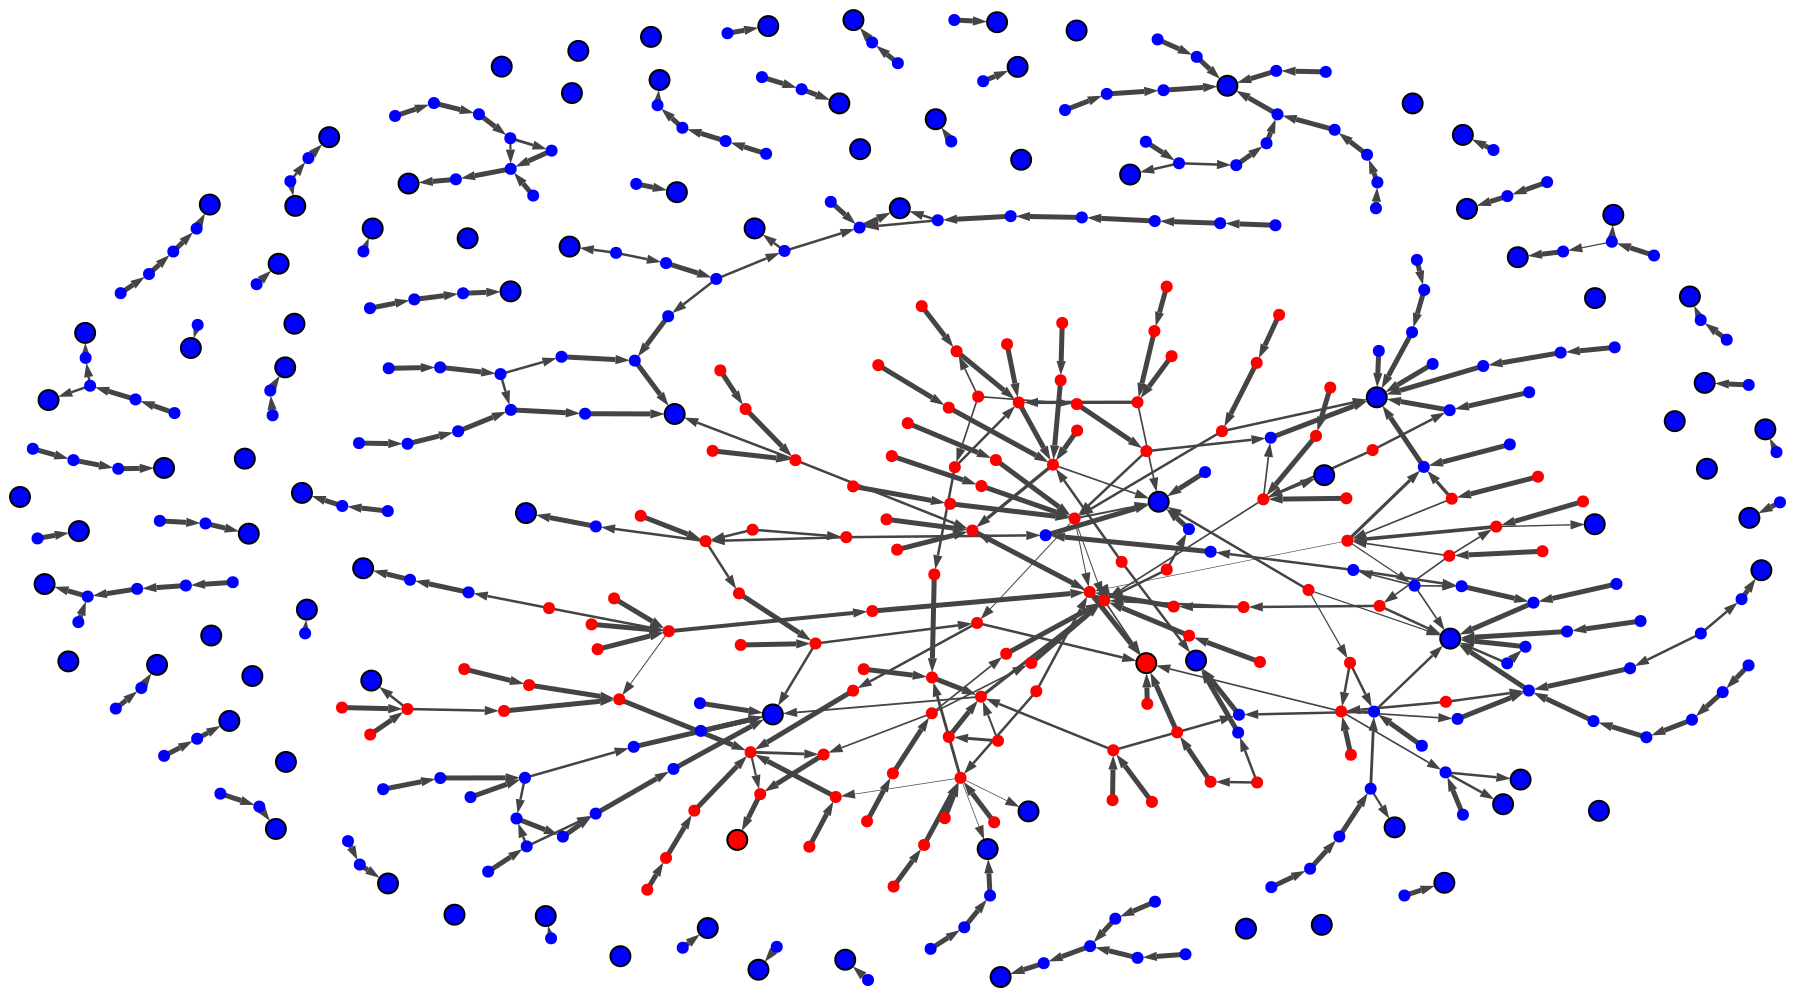

graphs/bays29_2_2.png


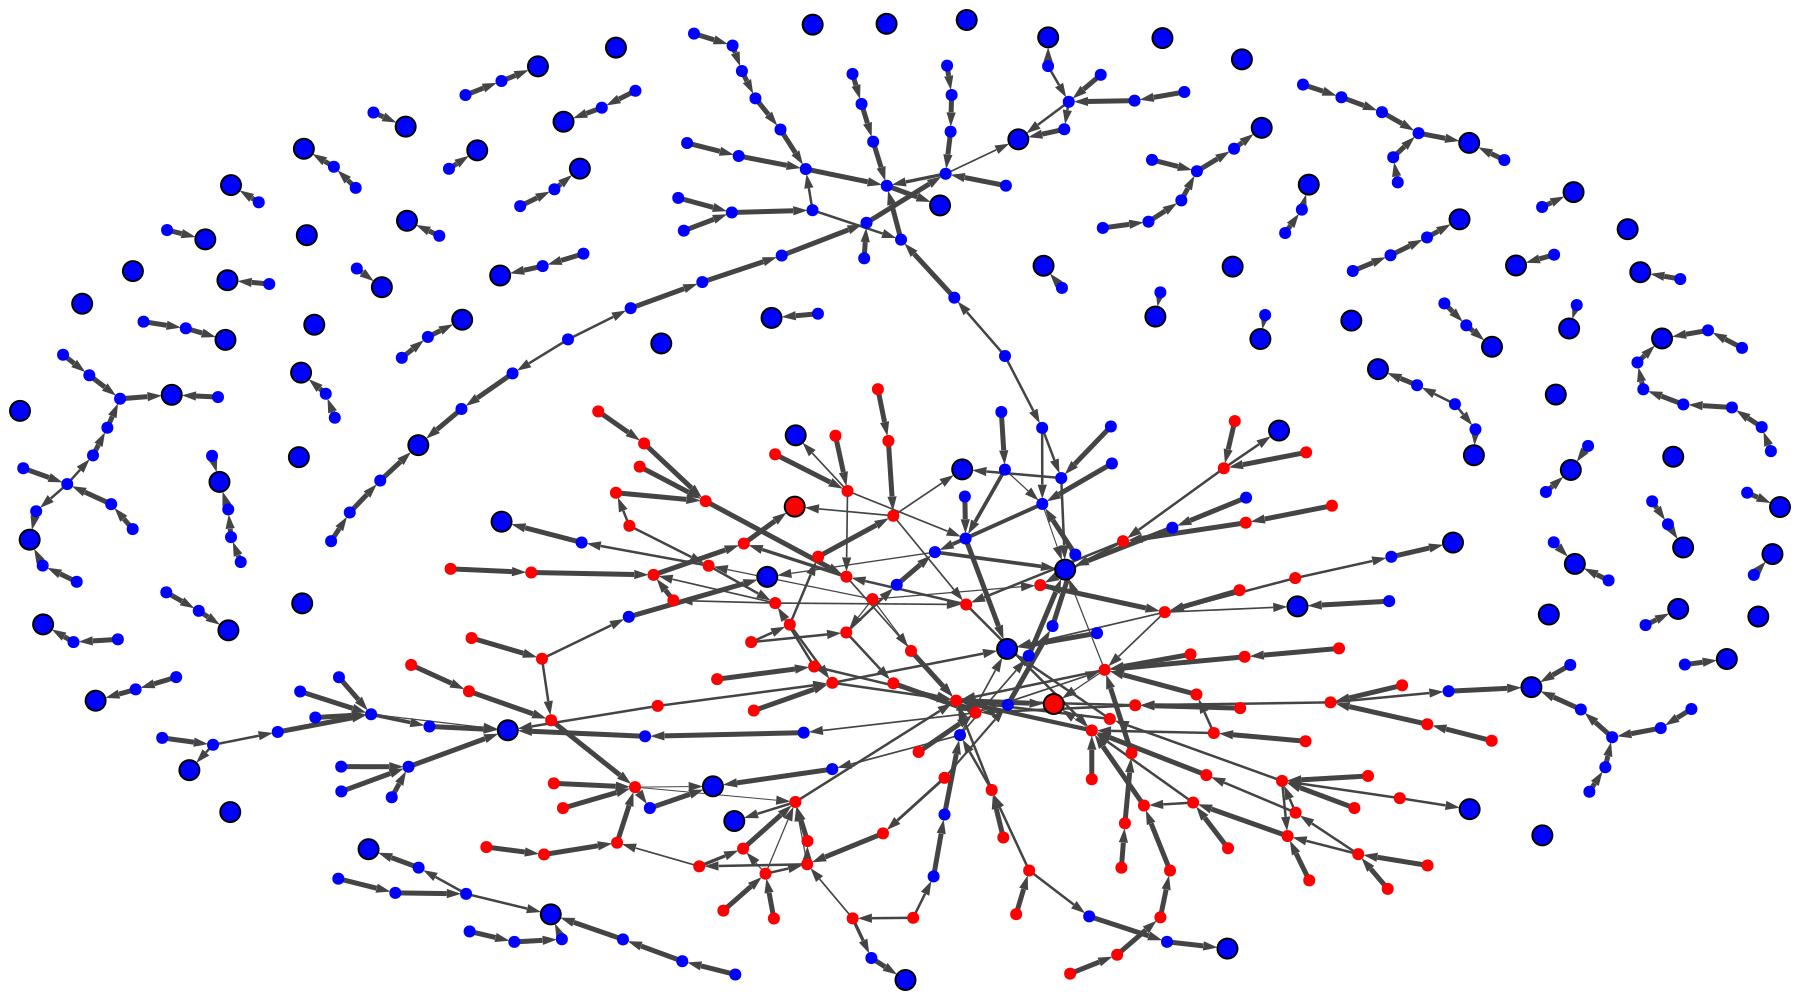

graphs/bays29_2_3.png


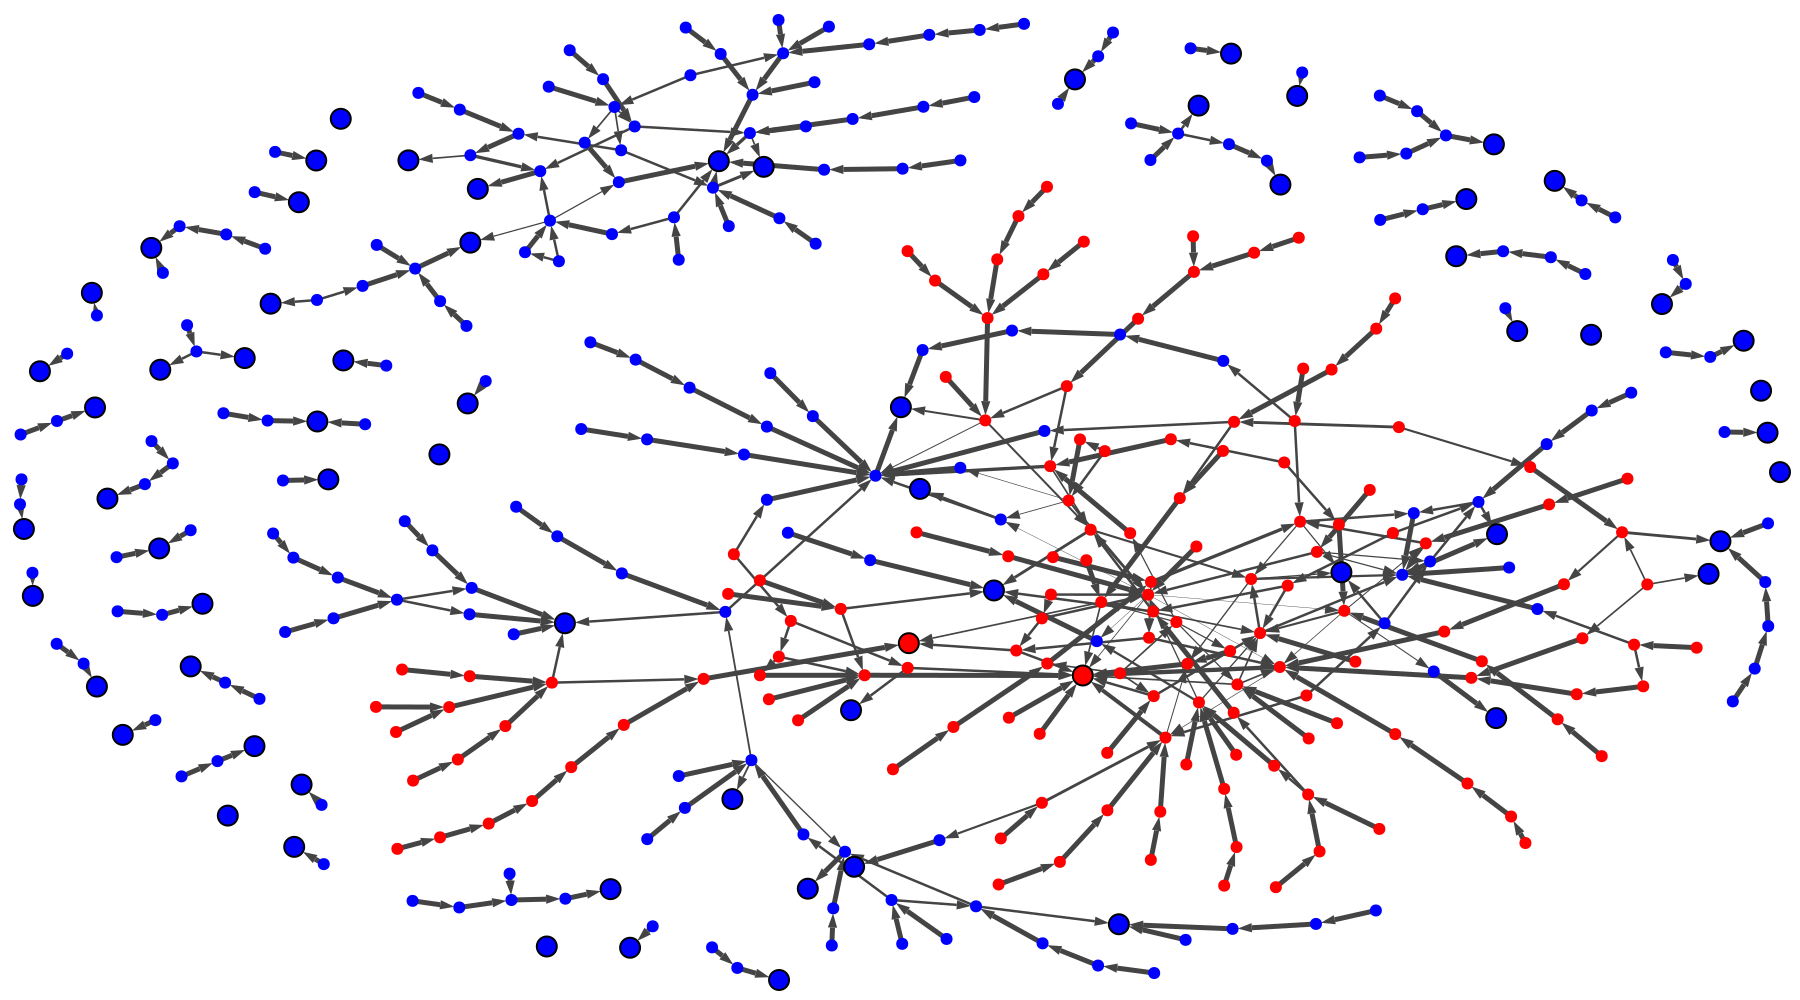

graphs/bays29_2_4.png


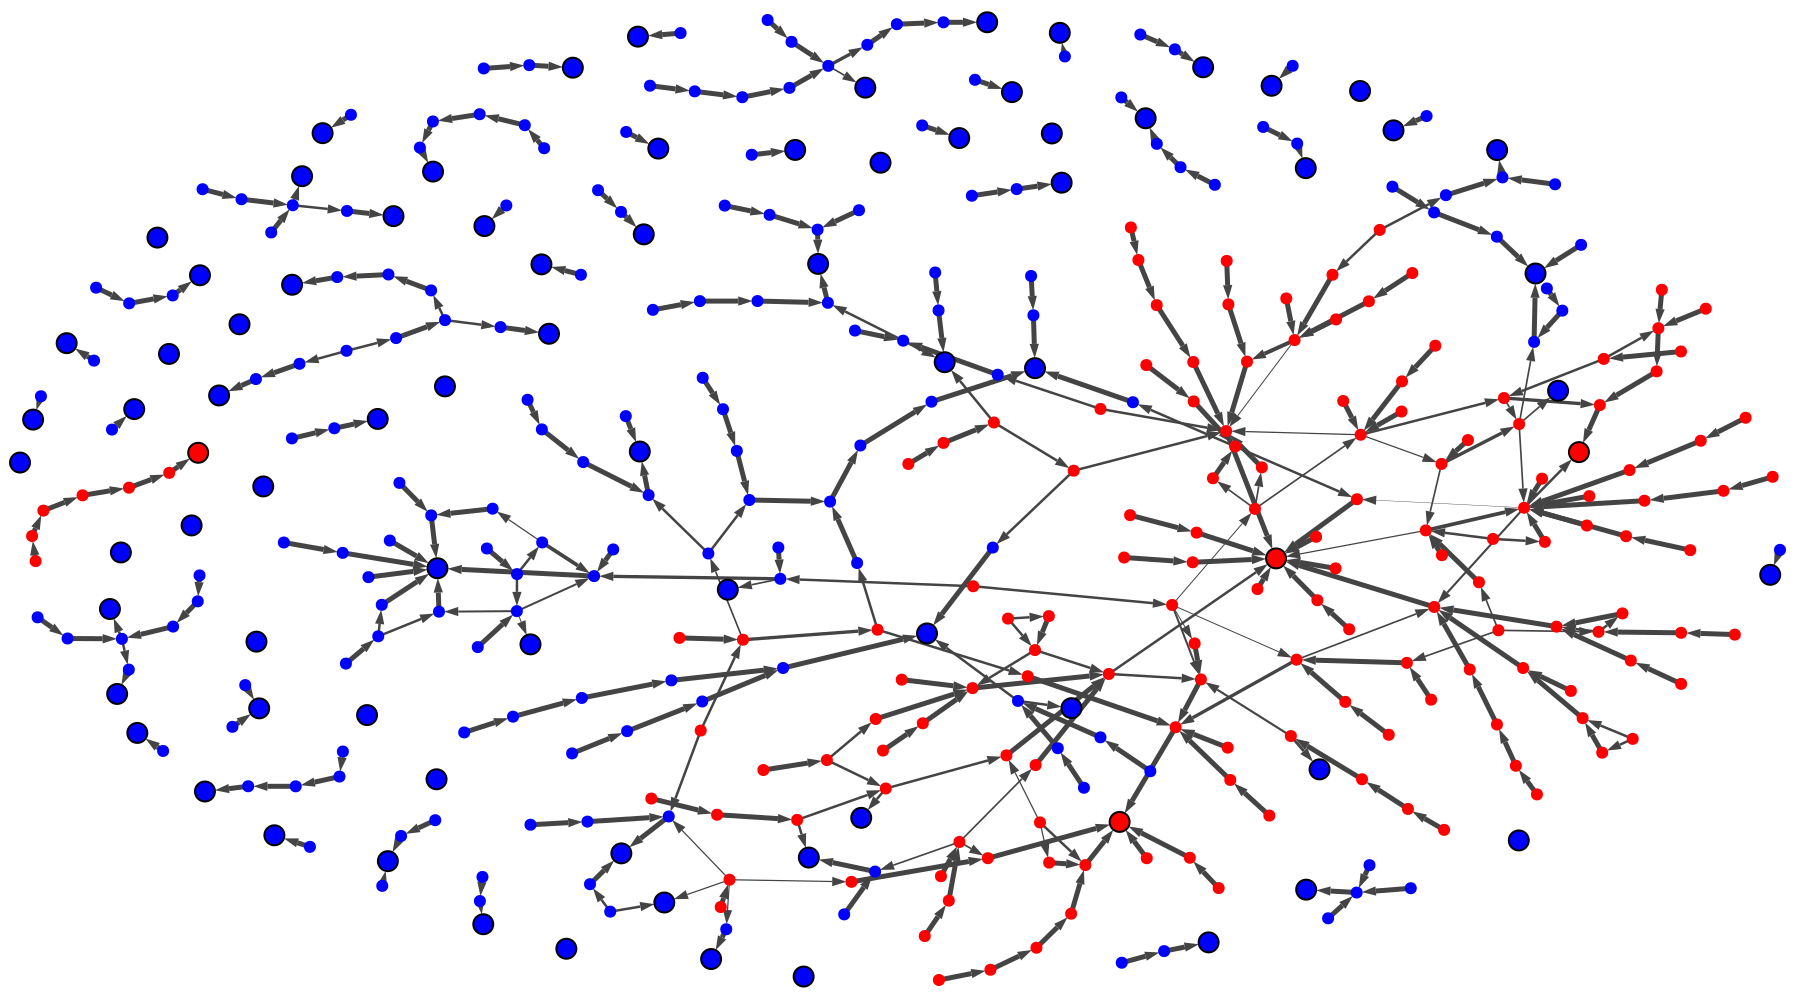

graphs/bays29_2_5.png


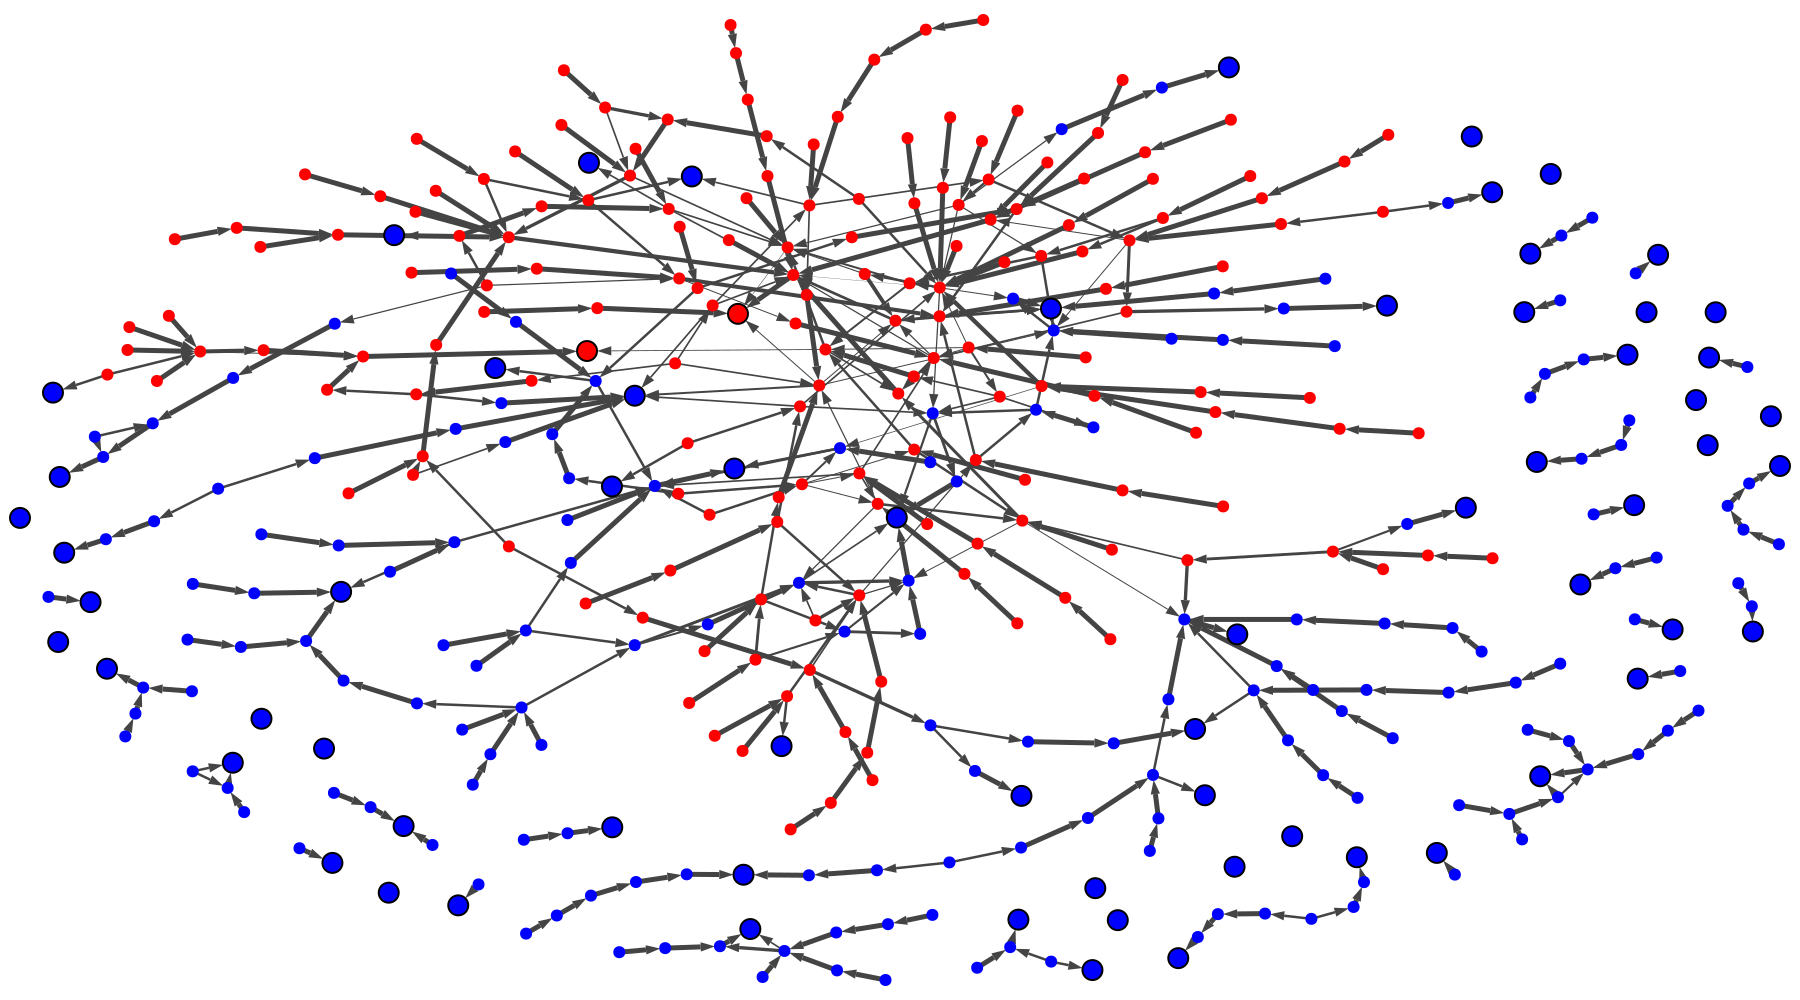

graphs/bays29_2_6.png


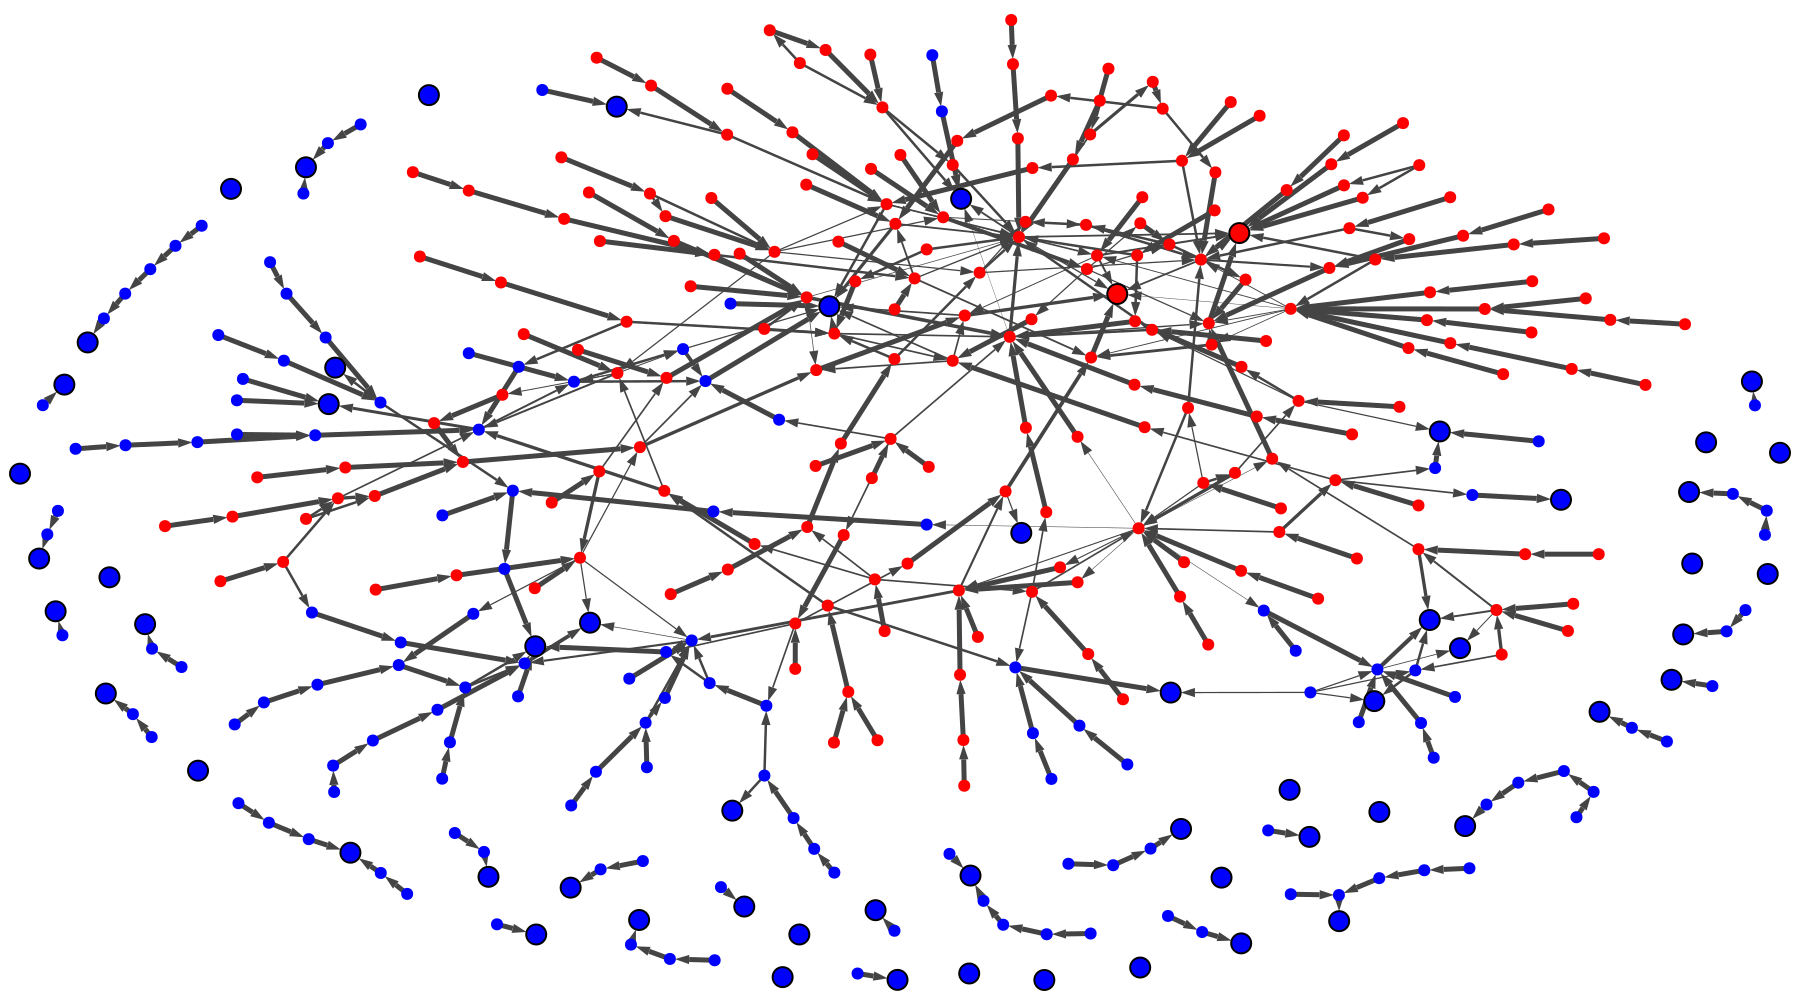

graphs/bays29_2_7.png


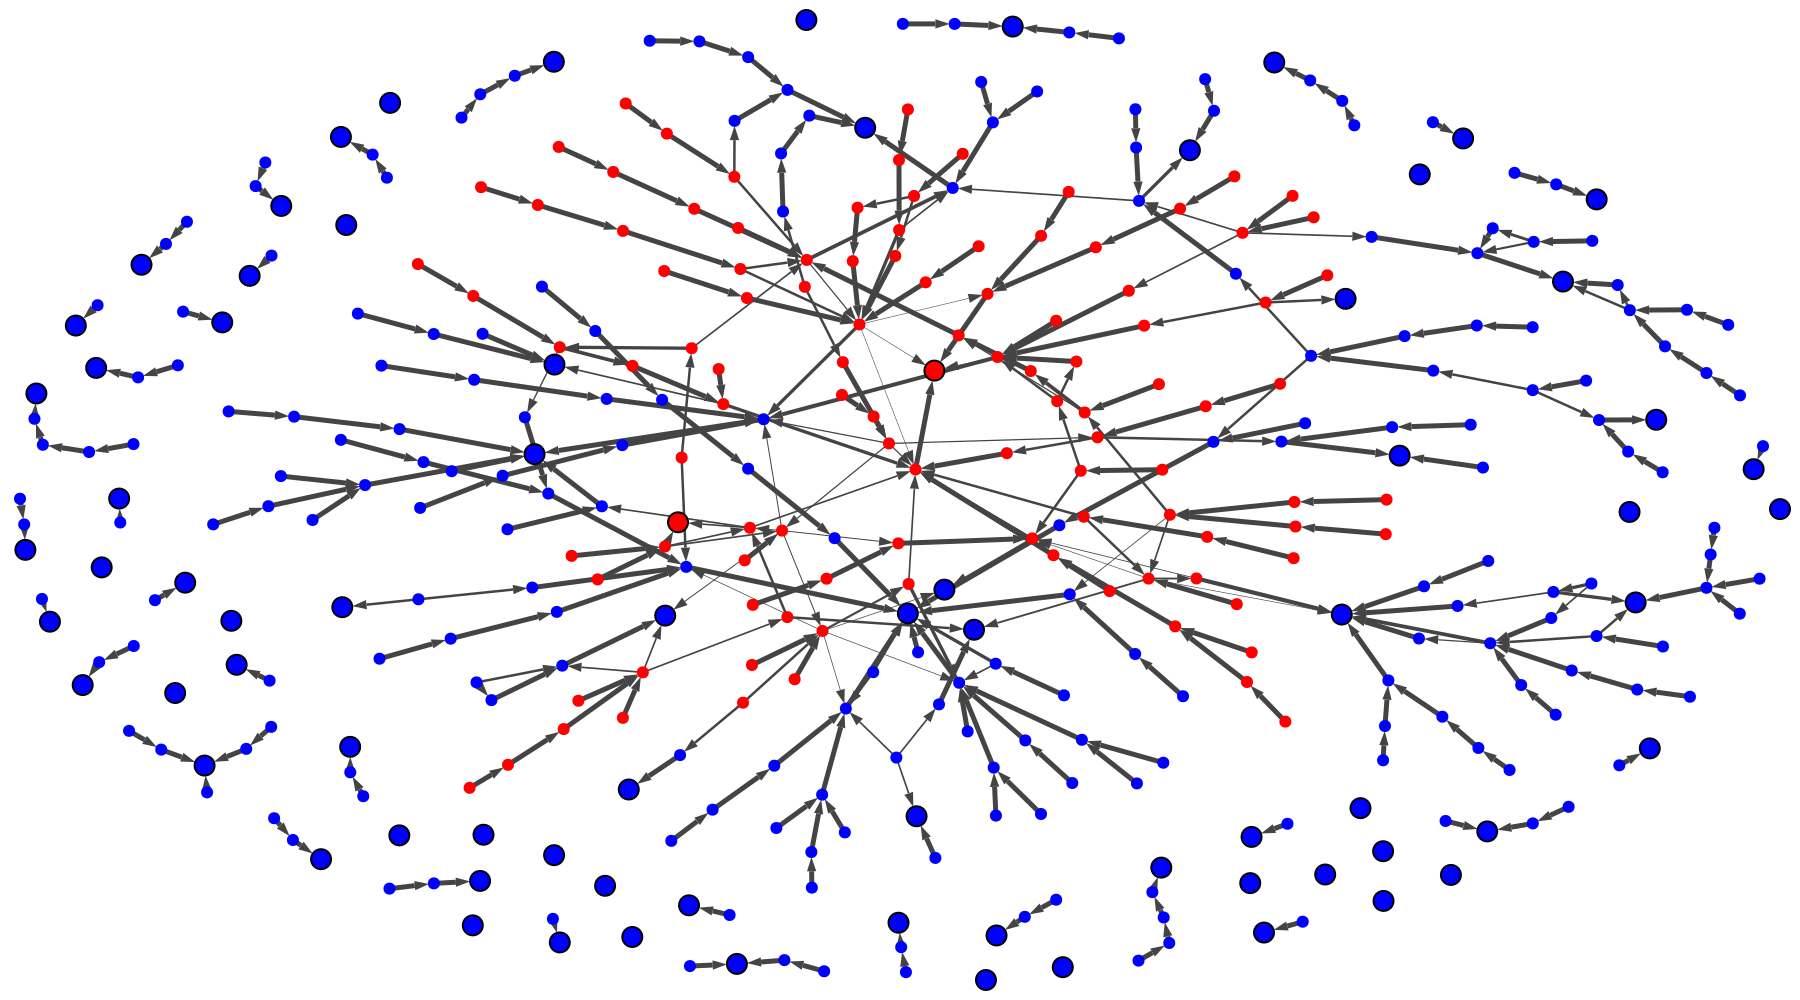

graphs/bays29_2_8.png


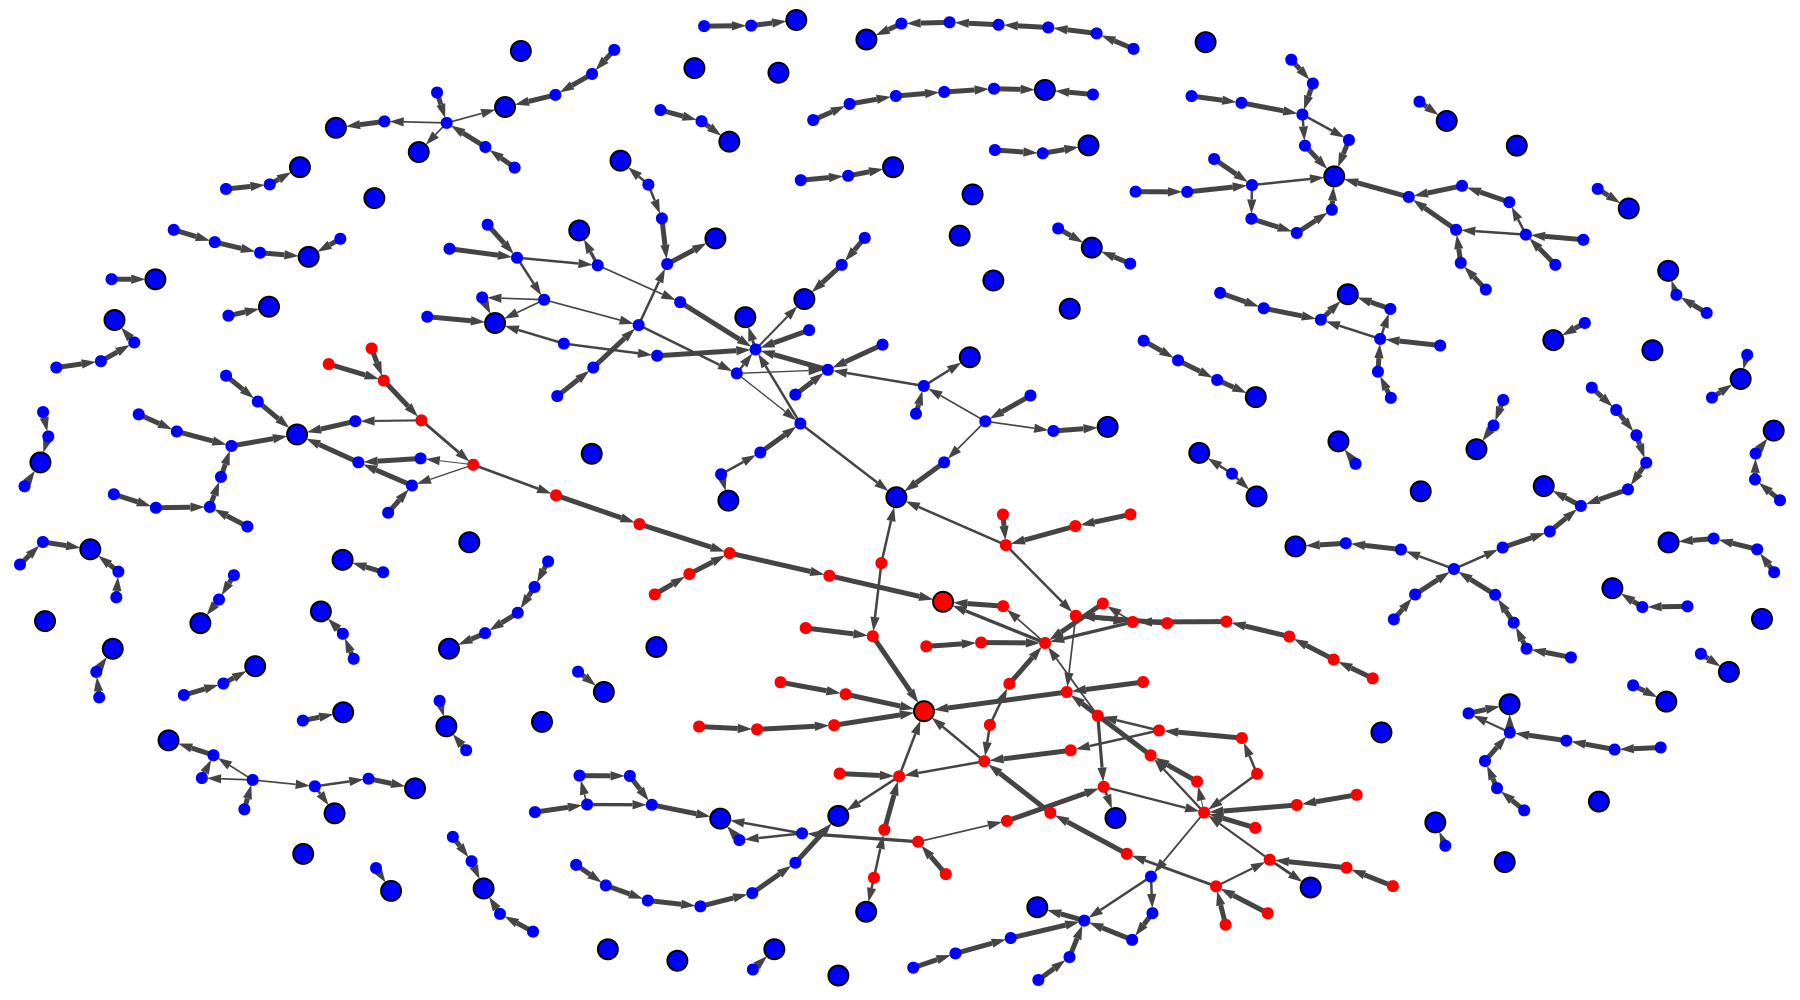

graphs/bays29_5_0.png


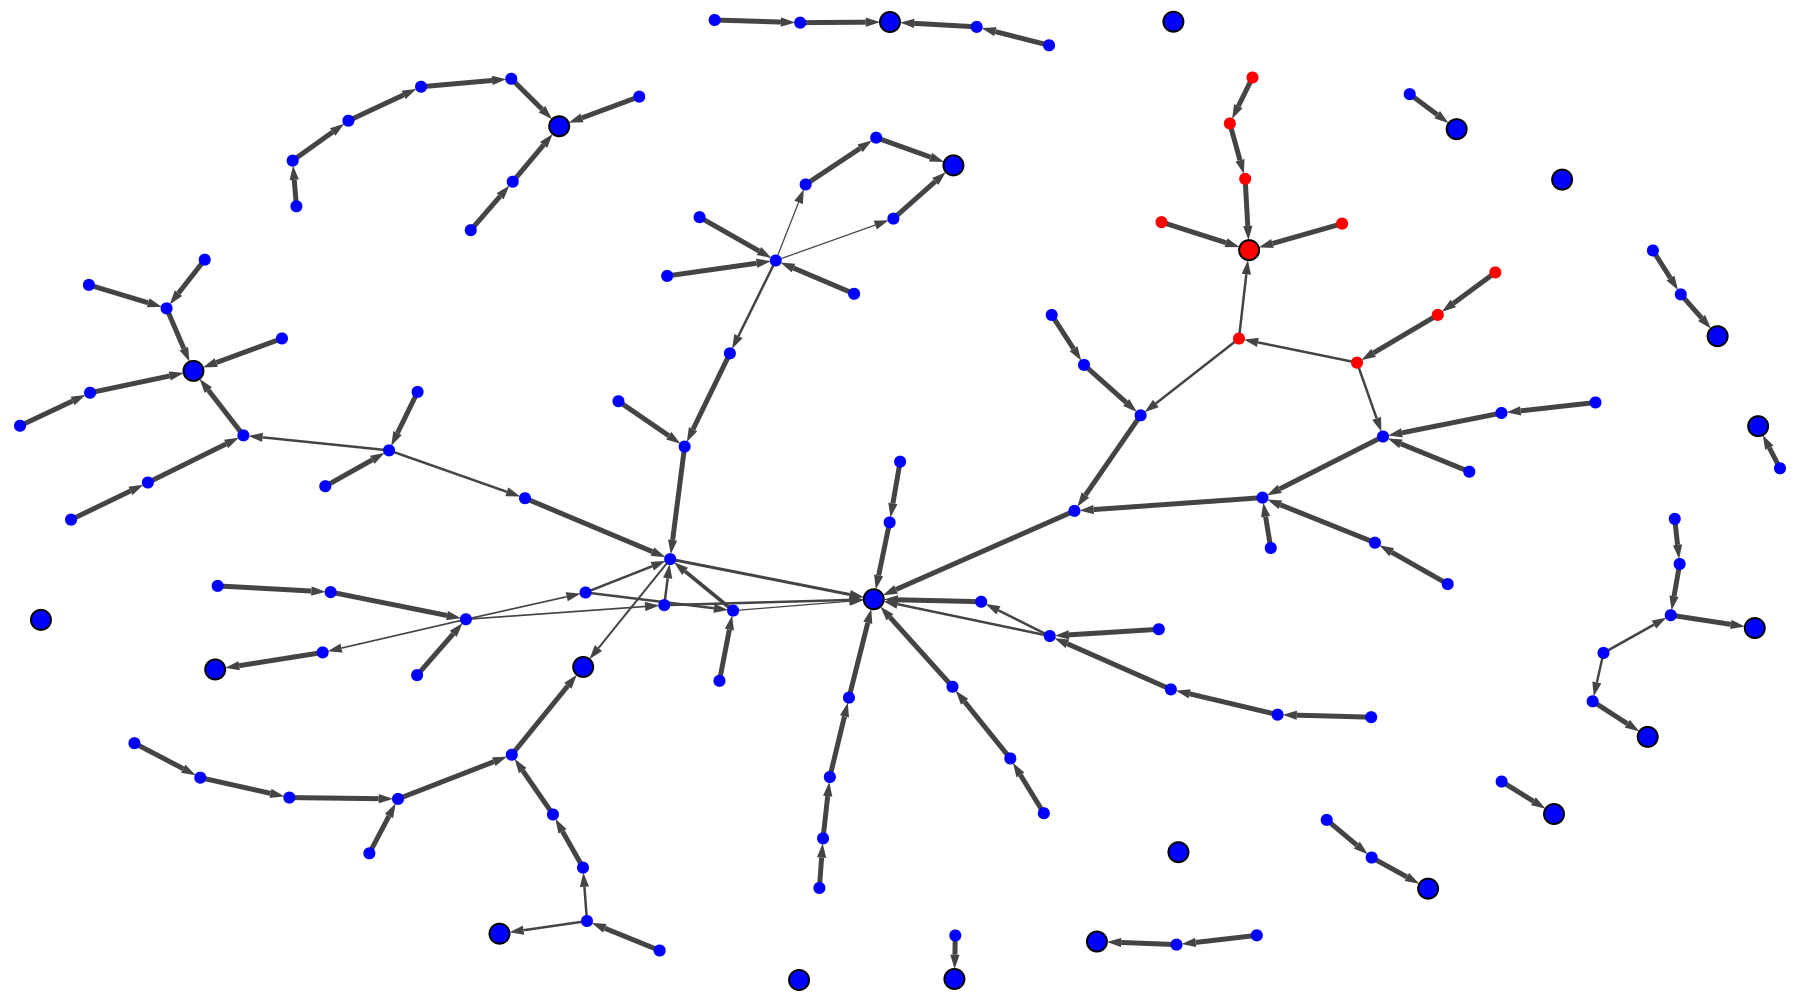

graphs/bays29_5_1.png


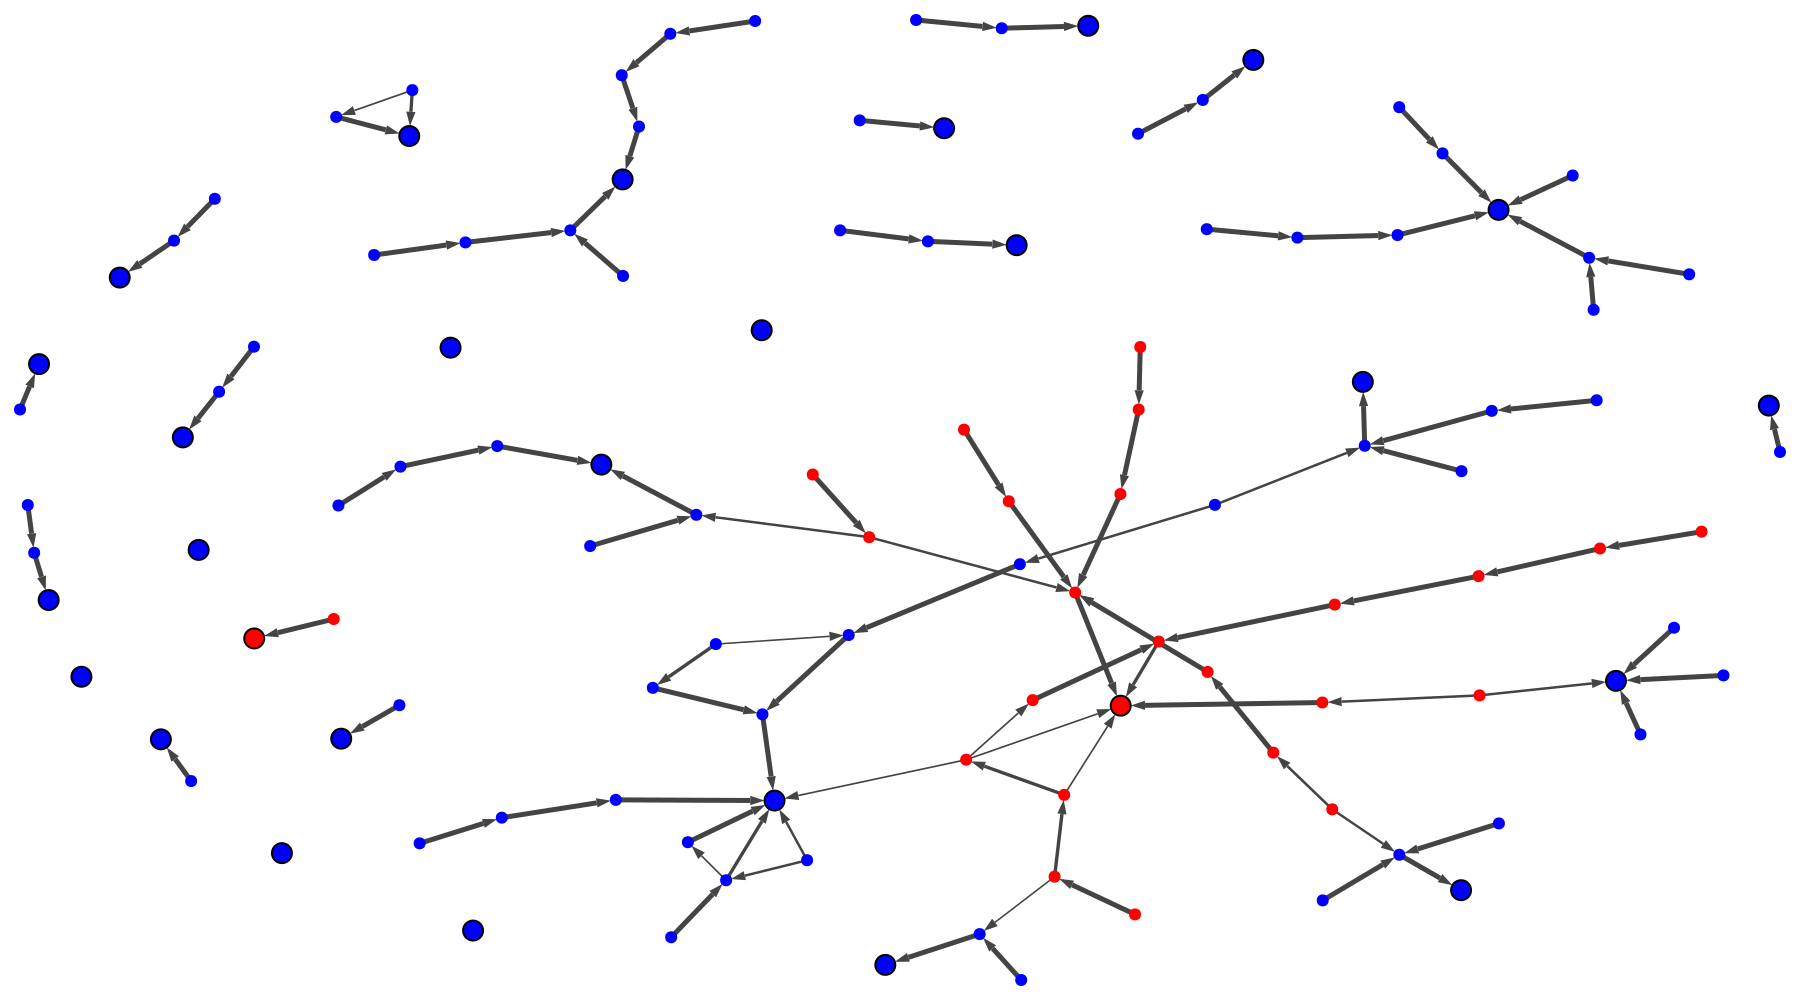

graphs/bays29_5_2.png


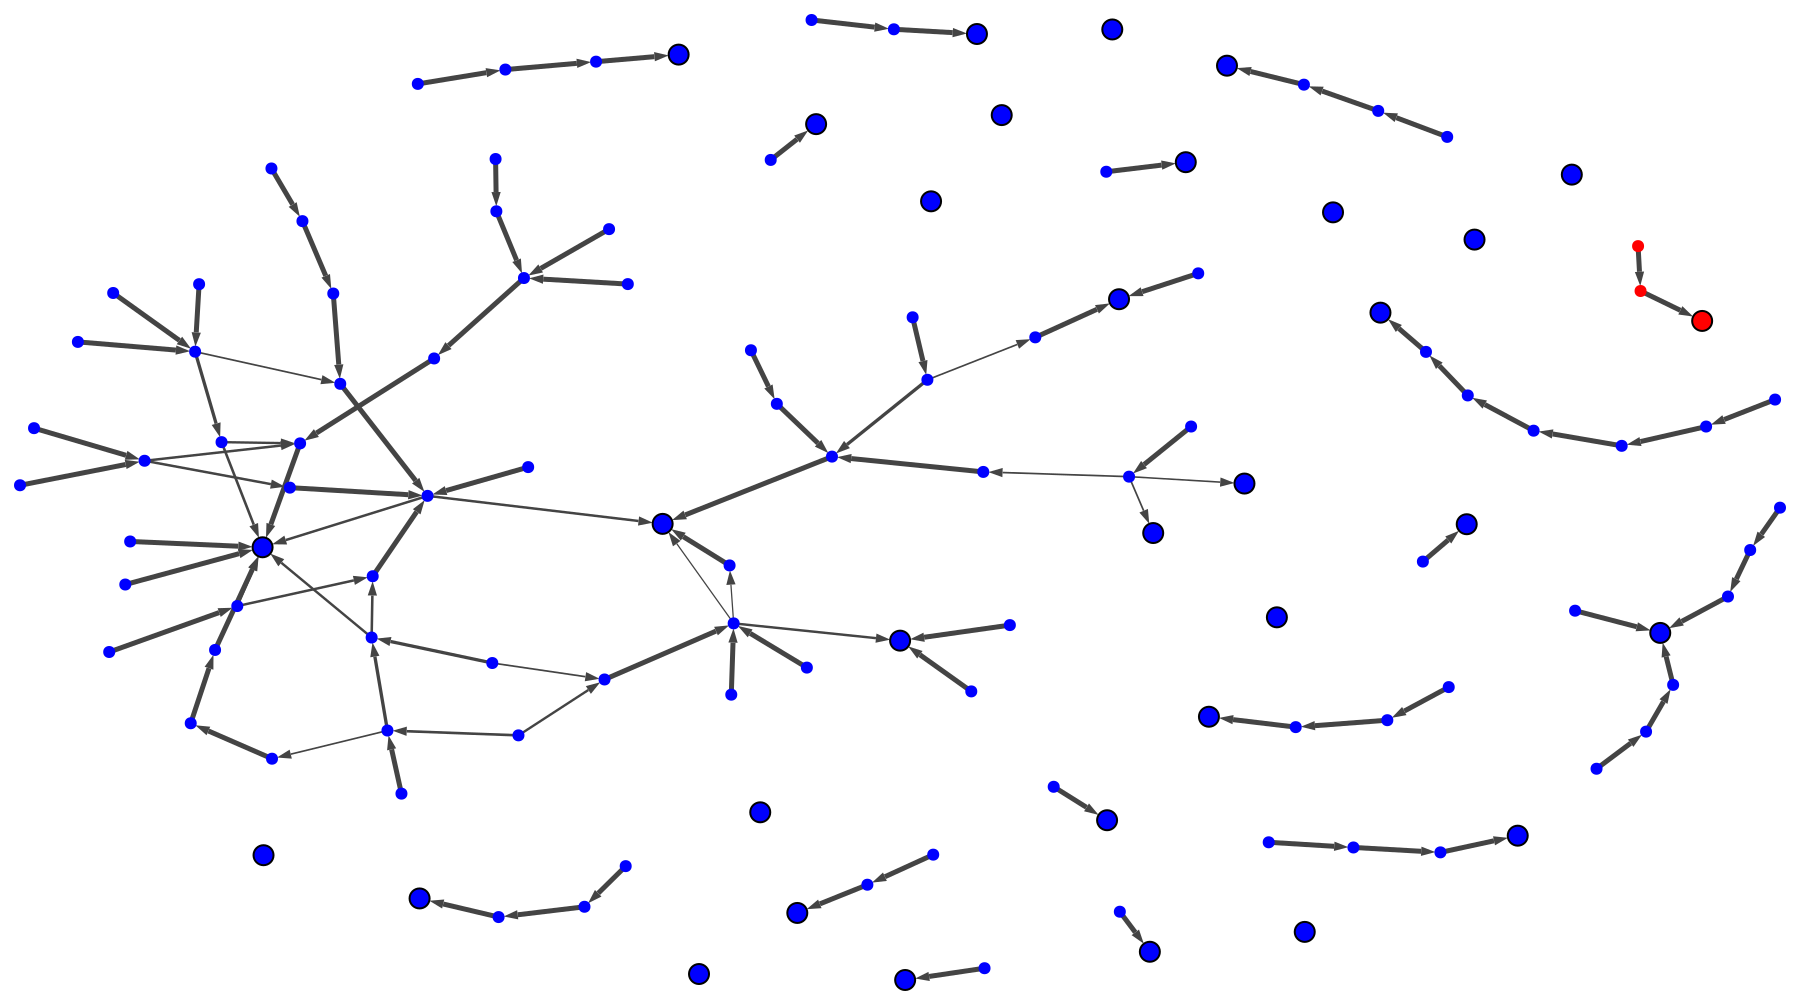

graphs/bays29_5_3.png


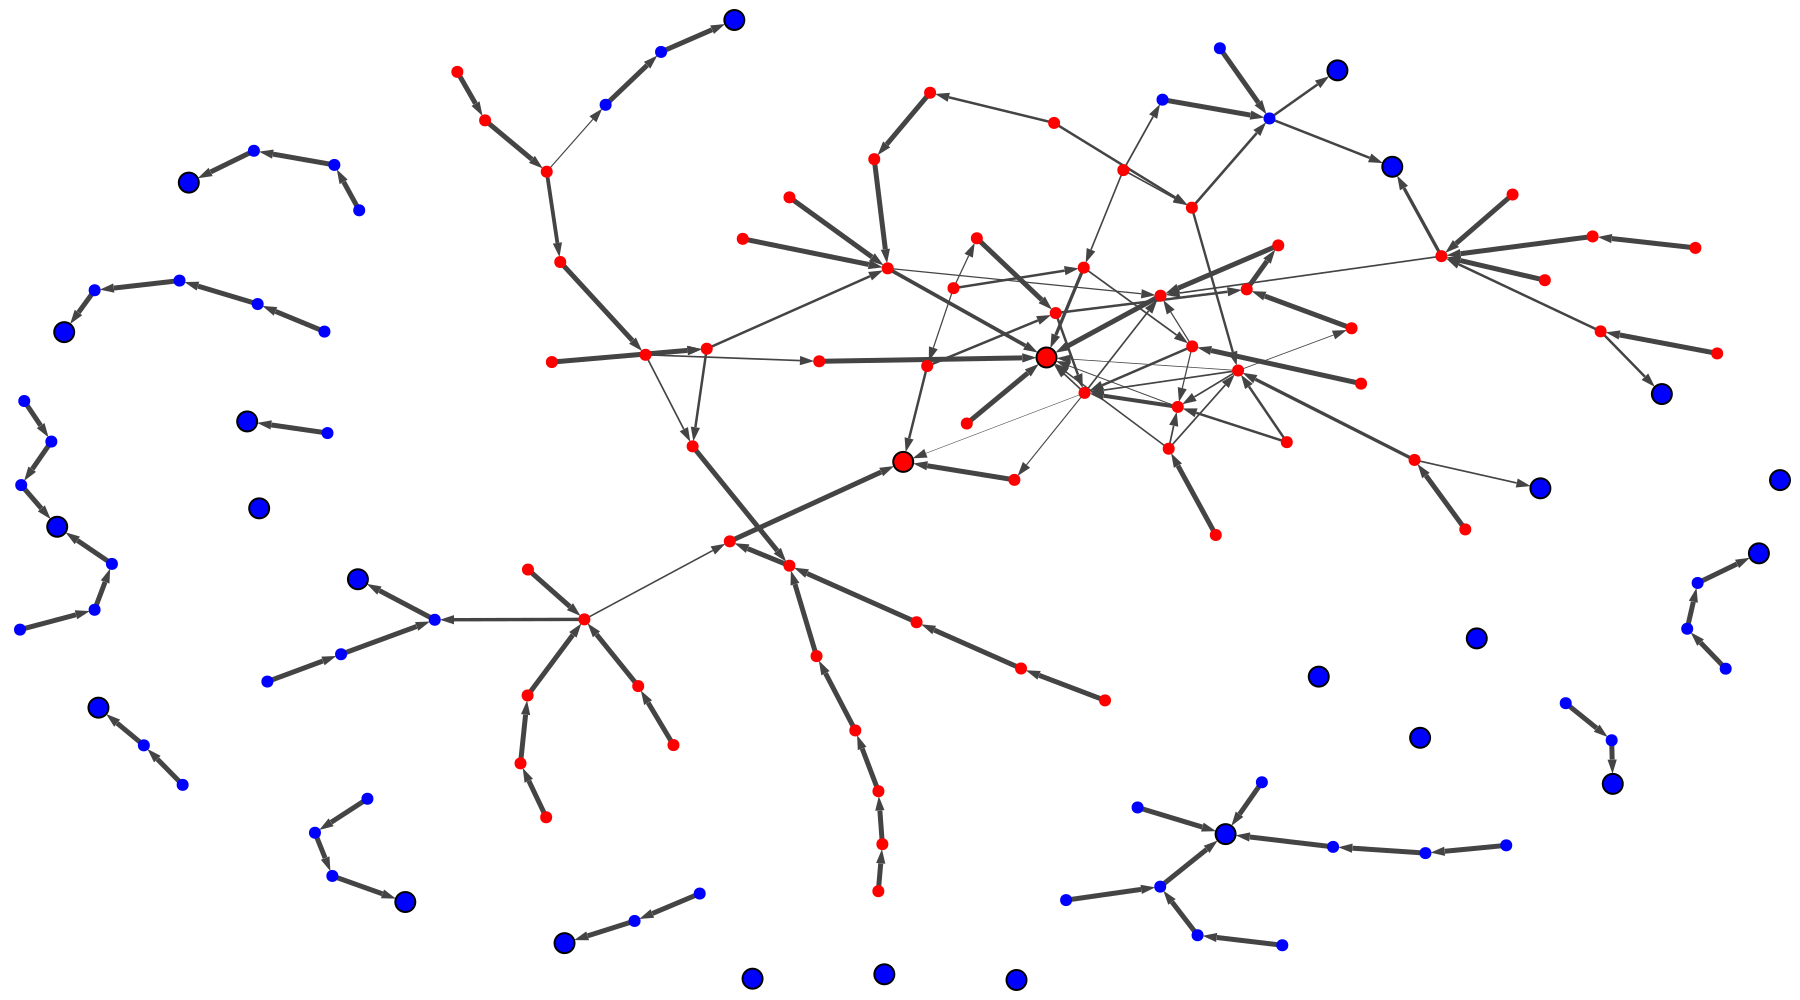

graphs/bays29_5_4.png


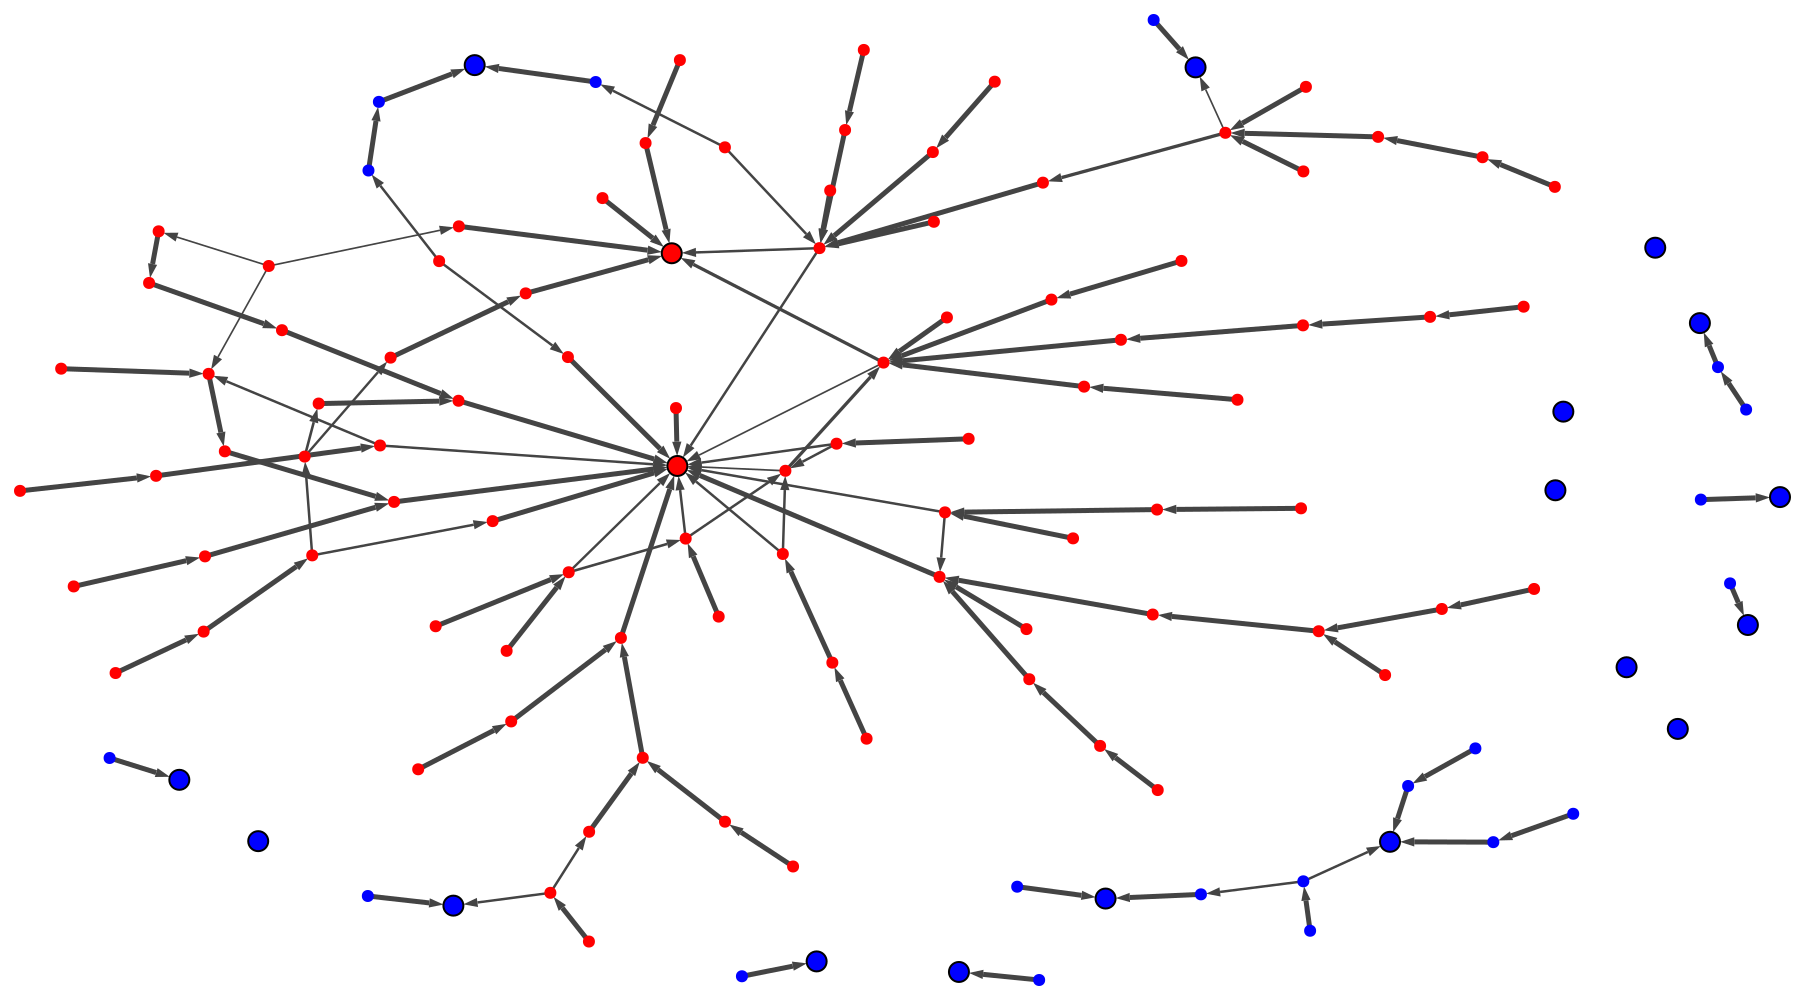

graphs/bays29_5_5.png


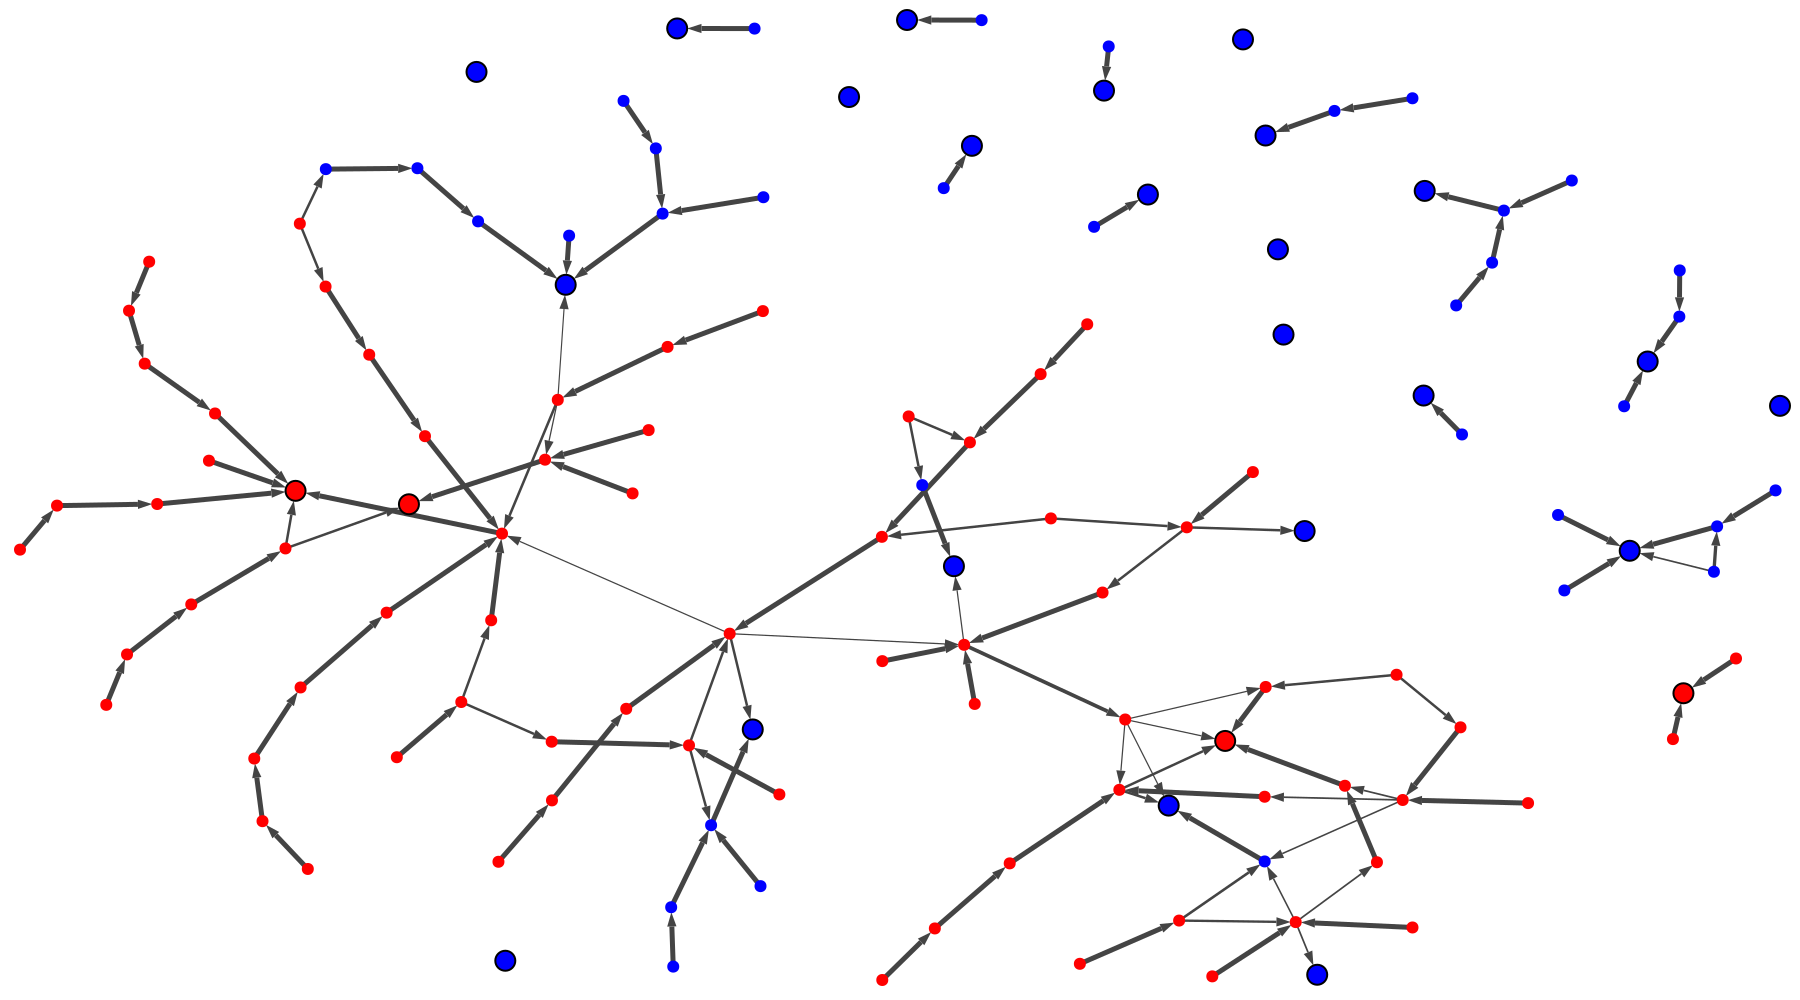

graphs/bays29_5_6.png


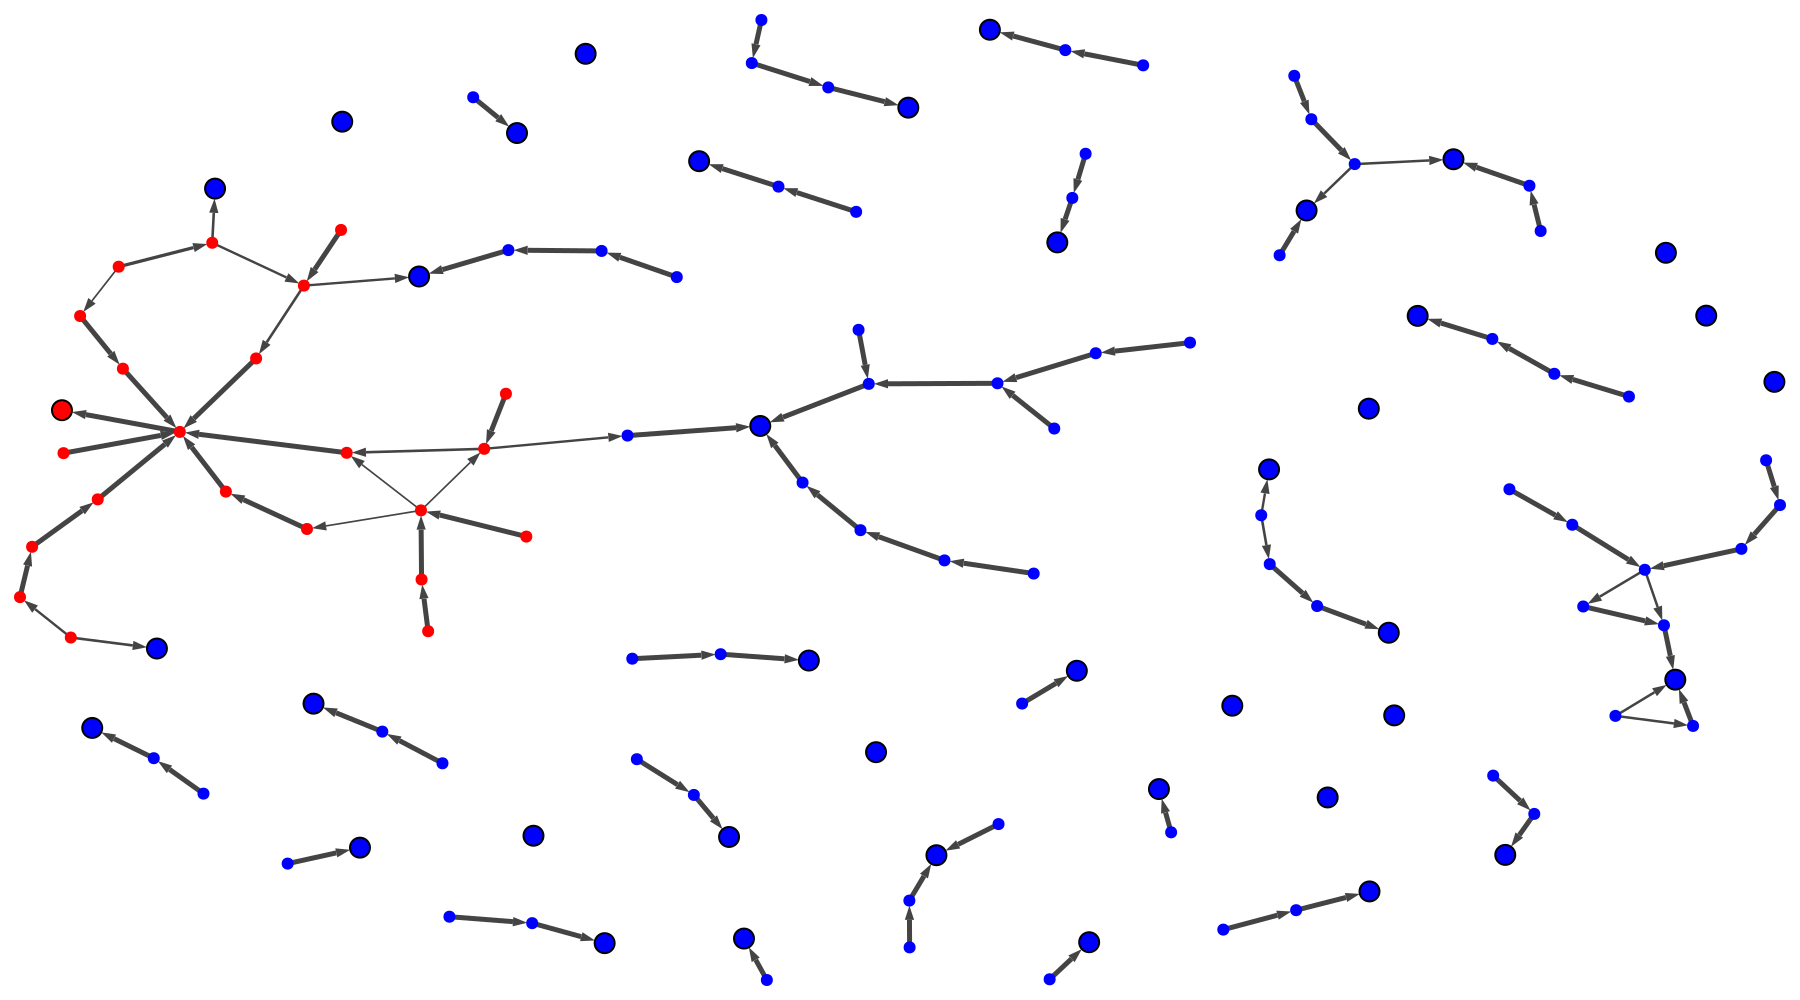

graphs/bays29_5_7.png


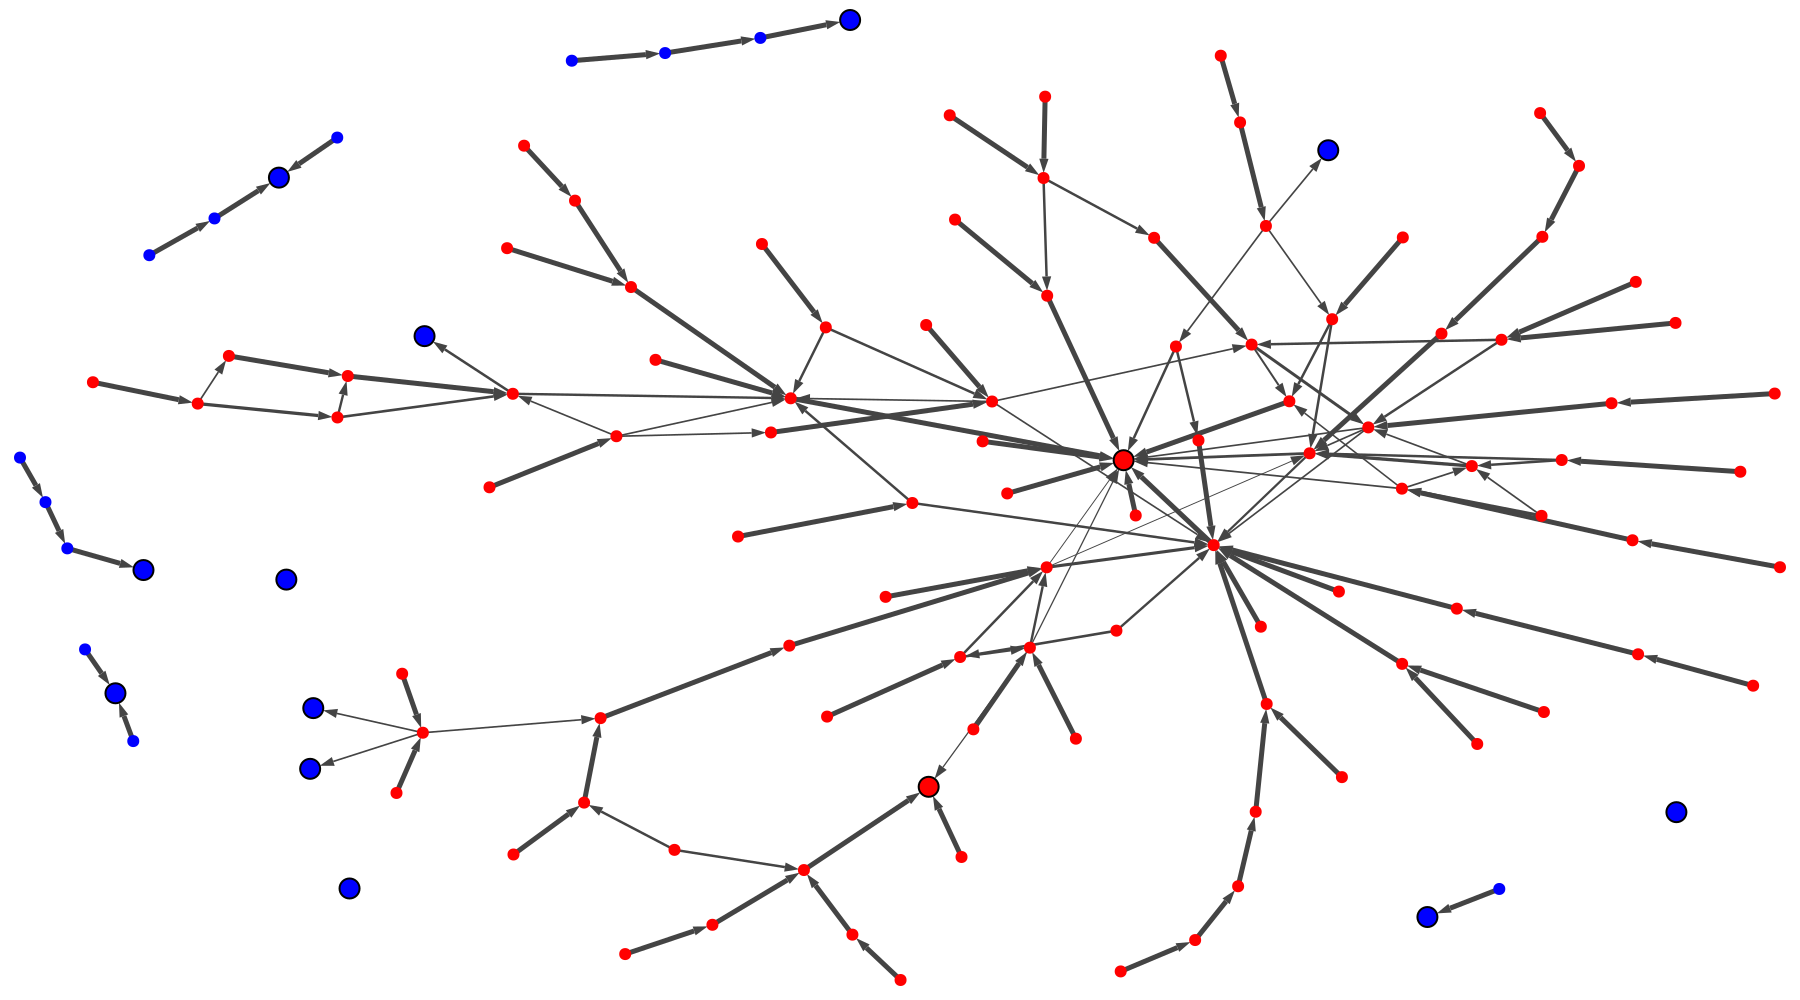

graphs/bays29_5_8.png


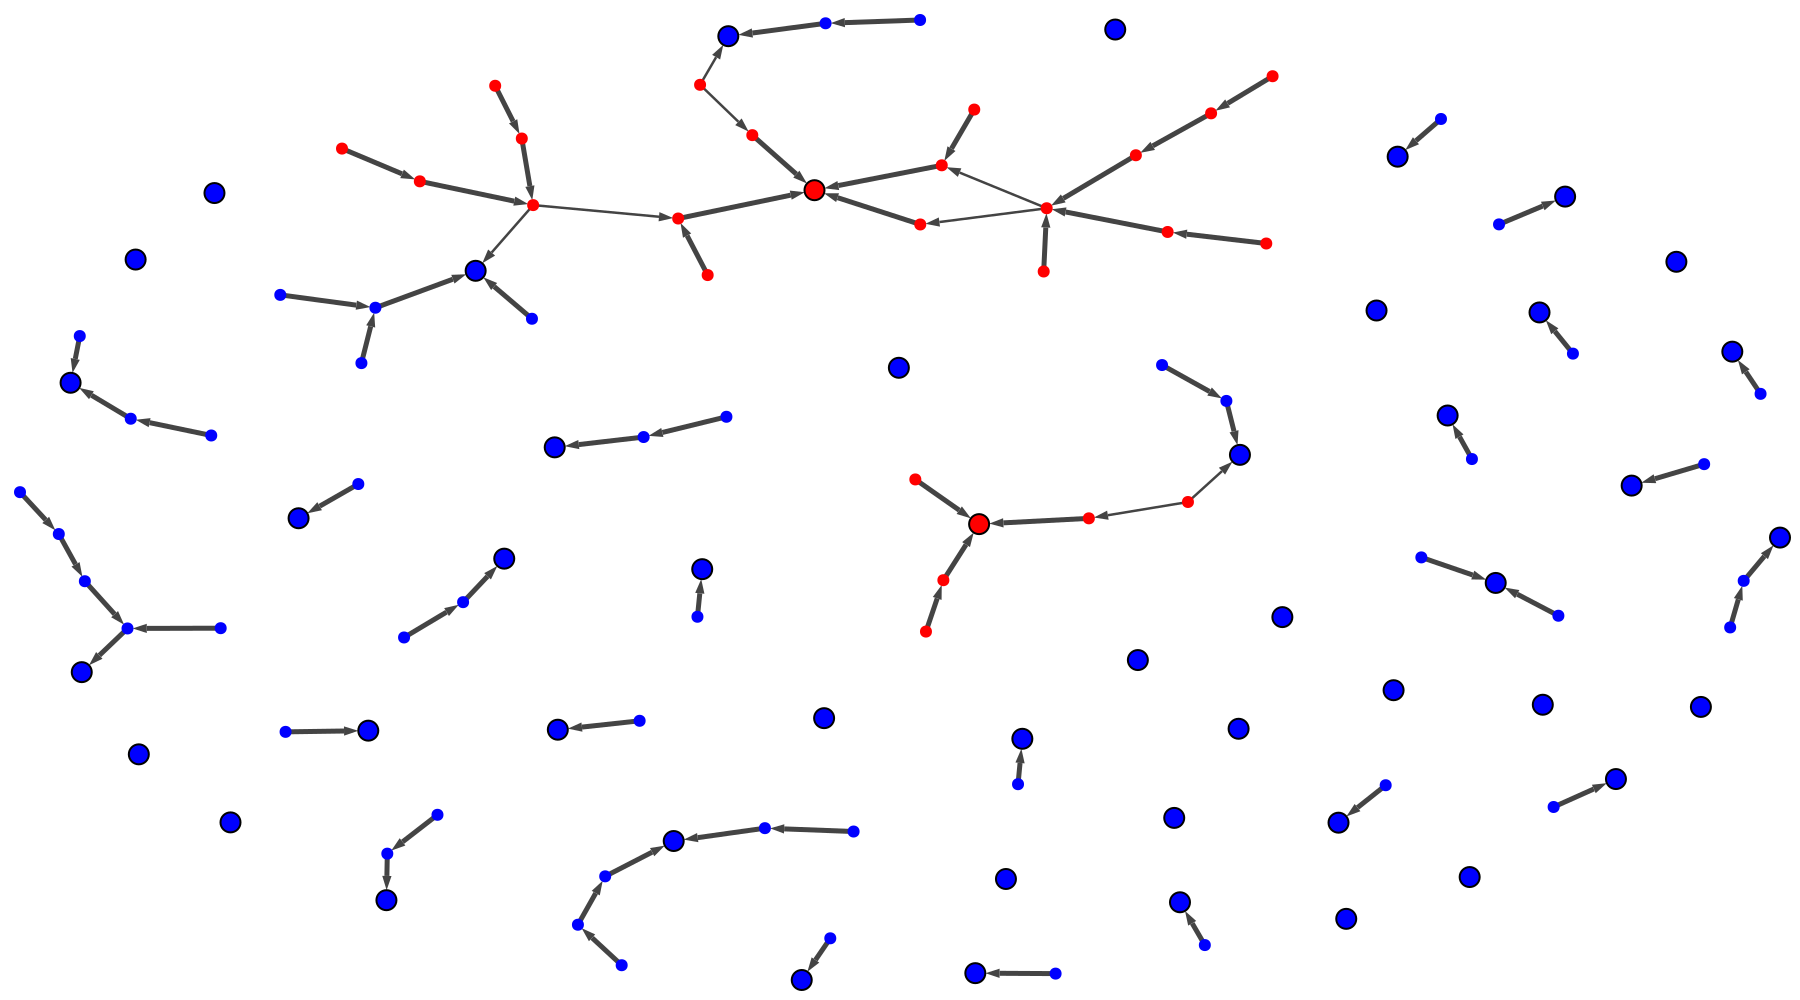

graphs/bays29_5_9.png


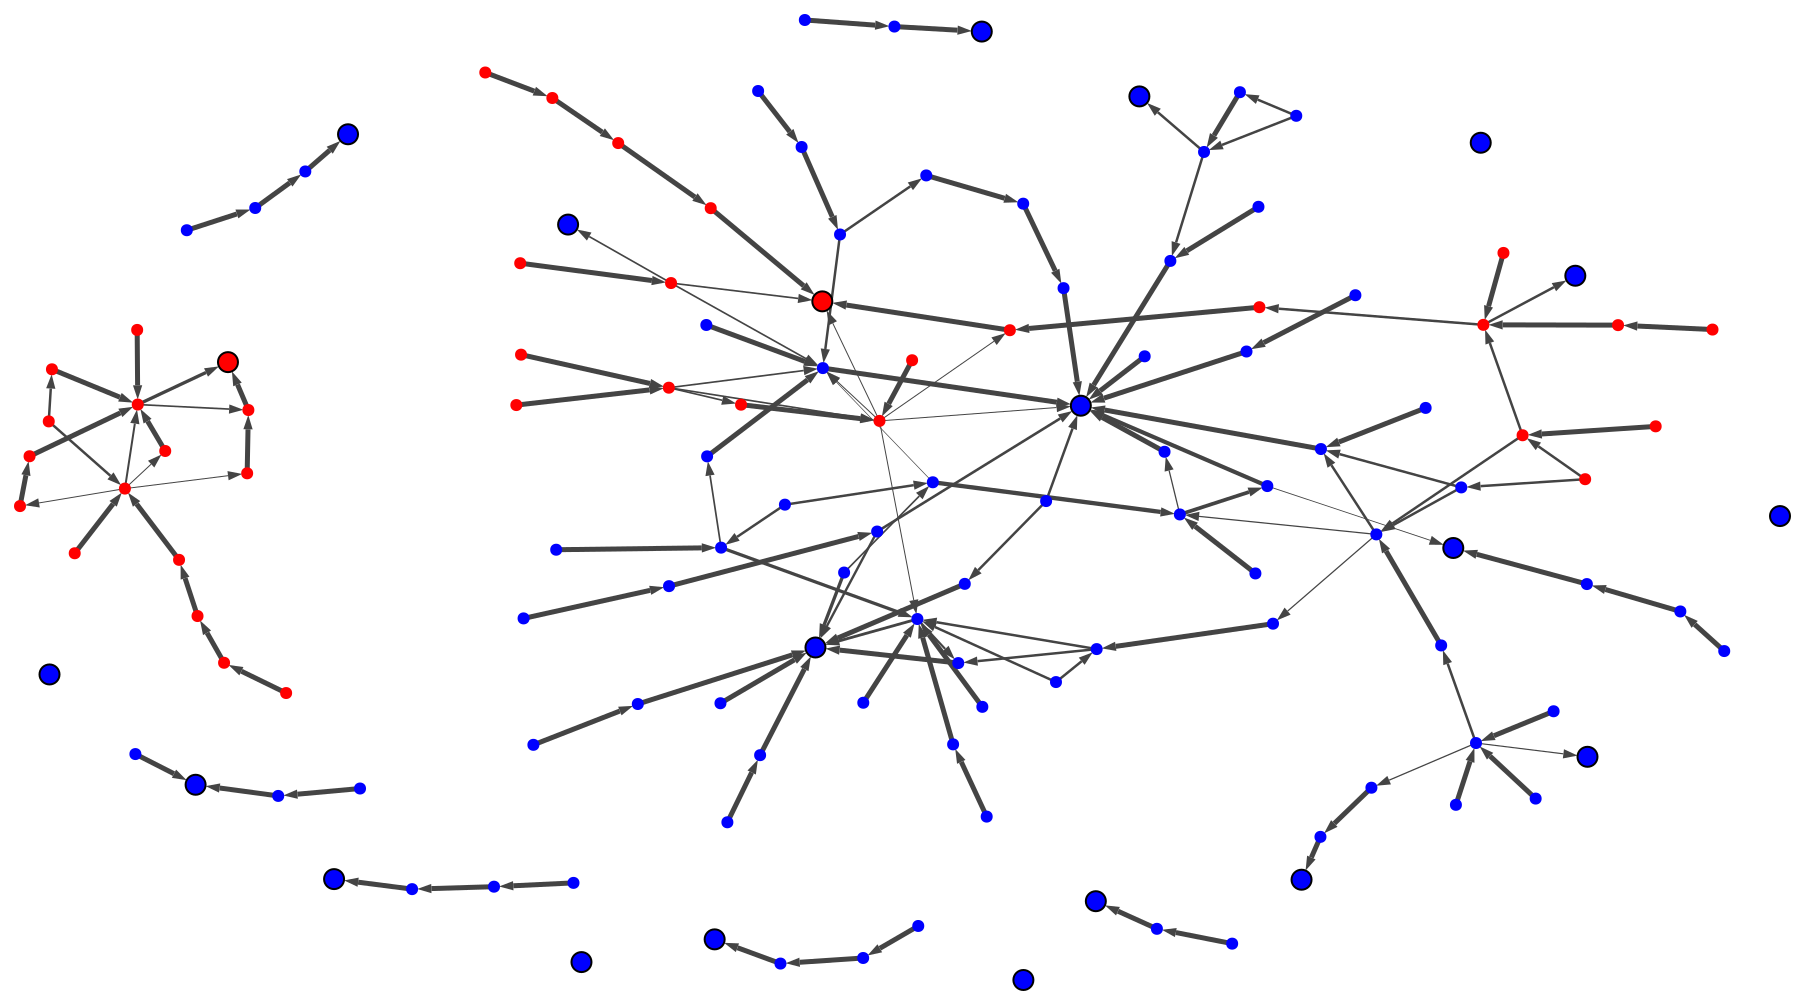

In [22]:
from pylab import imread,subplot,imshow,show

def print_subs(filename, T, s):
    for t in range(T):
        out_filename = filename + "_" + str(s) + "_" + str(t) + ".png"
        print(out_filename)
        img = Image(out_filename)
        display(img)

print_subs("graphs/bays29", 9, 1)
print_subs("graphs/bays29", 9, 2)
print_subs("graphs/bays29", 10, 5)
